# Data Collection

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#install
!pip install --quiet SimpleITK transformers

In [ ]:
#import
import tarfile
import torch
import os
import pandas as pd
import SimpleITK as sitk
import sklearn
from sklearn.model_selection import train_test_split
import transformers
from transformers import CLIPTextConfig, CLIPTokenizer, CLIPTextModel, AutoTokenizer

In [ ]:
#untar
def untar(inpath, outpath):
  my_tar = tarfile.open(inpath)
  my_tar.extractall(outpath)
  my_tar.close()

#get data
def get_data(data_path):
  image_path = data_path + 'imagesTr/'
  label_path = data_path + 'labelsTr/'
  patients = []
  for patient in sorted(os.listdir(image_path)):
    if '._' not in patient:
      image = image_path + patient
      label = label_path + patient
      patient = patient.replace('.nii.gz','')
      patients.append([patient, image, label])
  return pd.DataFrame(patients, columns = ['Patient', 'Image', 'Label'])

#resample image standardize
def resample_image(itk_image, out_size = (64, 64, 64), is_label = False):
  original_spacing = itk_image.GetSpacing()
  original_size = itk_image.GetSize()
  out_spacing = [original_size[0] * (original_spacing[0] / out_size[0]),
                 original_size[1] * (original_spacing[1] / out_size[1]),
                 original_size[2] * (original_spacing[2] / out_size[2])]
  resample = sitk.ResampleImageFilter()
  resample.SetOutputSpacing(out_spacing)
  resample.SetOutputOrigin(itk_image.GetOrigin())
  resample.SetSize(out_size)
  resample.SetOutputDirection(itk_image.GetDirection())
  resample.SetTransform(sitk.Transform())
  if is_label:
    resample.SetInterpolator(sitk.sitkNearestNeighbor)
  else:
    resample.SetInterpolator(sitk.sitkBSpline)
  return resample.Execute(itk_image)

#prepare
def prepare(fpath, mode, norm = sitk.NormalizeImageFilter()):
  image = sitk.ReadImage(fpath)
  if mode == 'image':
    image = resample_image(image, is_label = False)
    image = norm.Execute(image)
  if mode == 'label':
    image = resample_image(image, is_label = True)
    #cast and copy
    cast_image = sitk.Cast(image, sitk.sitkUInt8)
    cast_image.CopyInformation(image)
    image = cast_image
  return image

#split data
def split_data(df, test_size):
  #split
  df_train, df_val = train_test_split(df, test_size = test_size, random_state = 42)
  #update
  df_train['DATA'] = 'TRAIN'
  df_val['DATA'] = 'VAL'
  #combine
  df_new = pd.concat([df_train, df_val]).reset_index(drop = True)
  return df_new

#save image
def save_image(save_path, save_folder, patient, image):
  #save file
  if os.path.isdir(save_path + save_folder) == False:
    os.mkdir(save_path + save_folder)
  #save file
  save_loc = save_path + save_folder + '/' + patient + '.nii.gz'
  #write
  sitk.WriteImage(image, save_loc)
  #return
  return save_loc

#prepare data
def prepare_data(row, save_path, save_image_folder, save_label_folder):
  image = prepare(row['Image'], mode = 'image')
  label = prepare(row['Label'], mode = 'label')
  image_path = save_image(save_path, save_image_folder, row['Patient'], image)
  label_path = save_image(save_path, save_label_folder, row['Patient'], label)
  return image_path, label_path

#get bounding box no background and don't understand the coordinates
def get_bbox(label, label_shape_filter = sitk.LabelShapeStatisticsImageFilter()):
  label_shape_filter.Execute(label)
  num_labels = label_shape_filter.GetLabels()
  bboxes = torch.Tensor(len(num_labels), 6)
  for label_num in num_labels:
    bbox = label_shape_filter.GetBoundingBox(label_num)
    bboxes[label_num - 1, :] = torch.Tensor(bbox)[None, :]
  return bboxes.tolist()

#get text
def get_text(label, enc, label_shape_filter = sitk.LabelShapeStatisticsImageFilter()):
  label_shape_filter.Execute(label)
  num_labels = label_shape_filter.GetLabels()
  texts = []
  for num_label in num_labels:
    texts.append(enc[num_label])
  return texts

#rand rows
def rand_row(a, n = 1000):
  return a[torch.randperm(a.size()[0])][0:n,:]

#get bounding boxes
def bounding_boxes(pos_labels):
  max_val = torch.amax(pos_labels[:,0:3], dim = 0)
  min_val = torch.amin(pos_labels[:,0:3], dim = 0)
  return torch.concatenate([min_val, max_val], dim = 0).unsqueeze(0)

#coords pointsLabelShapeStatisticsImageFilter()):
def get_coords_points(label, label_shape_filter = sitk.LabelShapeStatisticsImageFilter()):
  #init
  x, y, z = label.GetSize()
  arr = torch.zeros((x * y * z, 4))
  a = 0
  for i in range(x):
    for j in range(y):
      for k in range(z):
        arr[a, 0] = i
        arr[a, 1] = j
        arr[a, 2] = k
        arr[a, 3] = label[i, j, k]
        a = a + 1
  #execute
  label_shape_filter.Execute(label)
  num_labels = label_shape_filter.GetLabels()
  point_labels = arr[:, 3]
  #iterate
  ls = []
  for num_label in num_labels:
    #get pos labels
    pos_labels = arr[point_labels == num_label]
    #get neg labels
    neg_labels = arr[(point_labels != num_label) & (point_labels != 0)]
    #get background labels
    back_labels = arr[point_labels == 0]
    #encode
    pos_labels[:, 3] = 1
    neg_labels[:, 3] = 0
    back_labels[:, 3] = -1
    #random rows (can't store all values)
    pos_labels = rand_row(pos_labels)
    neg_labels = rand_row(neg_labels)
    back_labels = rand_row(back_labels)
    #concat
    coords_labels = torch.concatenate([pos_labels, neg_labels, back_labels], dim = 0)
    #ls
    ls.append(torch.unsqueeze(coords_labels, dim = 0))
  #concat
  return torch.concatenate(ls, dim = 0).tolist()

#characterize
def characterize(row, save_label_folder, enc):
  label = sitk.ReadImage(row[save_label_folder])
  bboxes = get_bbox(label)
  coords_points = get_coords_points(label)
  texts = get_text(label, enc)
  return bboxes, coords_points, texts

#characterize
def characterize2(row, save_label_folder, enc):
  label = sitk.ReadImage(row[save_label_folder])
  bboxes, coords_points = get_coords_points_boxes(label)
  texts = get_text(label, enc)
  return bboxes, coords_points, texts

#create tokenizer
def create_tokenizer(text, save_folder, path = "openai/clip-vit-base-patch32", num_tokens = 10):
  old_tokenizer = AutoTokenizer.from_pretrained(path)
  tokenizer = old_tokenizer.train_new_from_iterator(text, num_tokens)
  tokenizer.save_pretrained(save_folder)

#load tokenizer
def load_tokenizer(save_folder):
  return AutoTokenizer.from_pretrained(save_folder)

#get the coordinates, labels, boxes
def get_coords_points_boxes(label, label_shape_filter = sitk.LabelShapeStatisticsImageFilter()):
  #execute
  label_shape_filter.Execute(label)
  #get num labels (nonzero)
  num_labels = label_shape_filter.GetLabels()
  #get sparse labels
  label = torch.Tensor(sitk.GetArrayFromImage(label)) + 1
  sparse_label = label.to_sparse()
  #get indices and vals
  point_labels = sparse_label.values() - 1
  coord_points = torch.concatenate([sparse_label.indices().T, point_labels.unsqueeze(1)], dim = 1)
  #init
  ls_coords = []
  ls_boxes = []
  #iterate
  for num_label in num_labels:
    #get pos labels
    pos_labels = coord_points[point_labels == num_label]
    #get neg labels
    neg_labels = coord_points[(point_labels != num_label) & (point_labels != 0)]
    #get background labels
    back_labels = coord_points[point_labels == 0]
    #get bounding boxes from pos labels
    boxes = bounding_boxes(pos_labels)
    #encode
    pos_labels[:, 3] = 1
    neg_labels[:, 3] = 0
    back_labels[:, 3] = -1
    #random rows (can't store all values)
    pos_labels = rand_row(pos_labels)
    neg_labels = rand_row(neg_labels)
    back_labels = rand_row(back_labels)
    #concat
    coords_labels = torch.concatenate([pos_labels, neg_labels, back_labels], dim = 0)
    #ls
    ls_coords.append(torch.unsqueeze(coords_labels, dim = 0))
    #ls
    ls_boxes.append(boxes)
  #concat
  output_coords = torch.concatenate(ls_coords, dim = 0).tolist()
  #concat
  output_boxes = torch.concatenate(ls_boxes, dim = 0).tolist()
  #return
  return output_boxes, output_coords

In [ ]:
#main
untar('/content/gdrive/MyDrive/SAMMI/data/MSD/Task04_Hippocampus.tar', '/content/')

In [ ]:
#init
data_path = '/content/Task04_Hippocampus/'
val_size = 0.8
save_path = '/content/gdrive/MyDrive/SAMMI/preprocessing/'
save_image_folder = 'Norm_Image_64'
save_label_folder = 'Label_64'
enc = {1: 'anterior hippocampus', 2: 'posterior hippocampus'}

In [ ]:
%%time
#main
df = get_data(data_path)
#split files
df = split_data(df, val_size)
#row
df[save_image_folder], df[save_label_folder] = zip(*df.apply(prepare_data, axis = 1,
                                                             args = (save_path, save_image_folder, save_label_folder)))
#collect some more intel, bounding box, text, points
df['Input_BBoxes'], df['Input_Coords_Points'], df['Input_Text'] = zip(*df.apply(characterize2, axis = 1,
                                                                                args = (save_label_folder, enc)))
#save
df.to_pickle(save_path + 'df_inputs_64.pkl')
#create the custom tokenizer
create_tokenizer(list(enc.values()), save_path + 'tokenizer')

CPU times: user 2min 6s, sys: 3.46 s, total: 2min 9s
Wall time: 2min 31s


# Training

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#install
!pip install --quiet SimpleITK monai wandb transformers einops livelossplot

In [ ]:
#imports
import os
import matplotlib.pyplot as plt
import pandas as pd
import json
import SimpleITK as sitk
import torch
import torchvision
import random
import sys
import time
import torch.backends.cudnn as cudnn
import datetime
from datetime import datetime
import wandb
import monai
import livelossplot
from livelossplot import PlotLosses
import transformers
from transformers import CLIPTextConfig, CLIPTokenizer, CLIPTextModel, AutoTokenizer
import einops
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Optional, Tuple, Type, List, Dict
from torch import Tensor
import math
import numpy as np

if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

#wanddb
key = "0ededc30a9b327450989bd6593cec2dbb642fc7a" #specify wandb key
#Weights and Bias
if key:
  wandb.login(key=key) #API Key is in your wandb account, under settings

Device:  Tesla T4


wandb: Currently logged in as: anishsalvi-osail. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#Image Encoder

# Copyright (c) ImageRx and Anish Salvi.
# All rights reserved.

class LayerNorm3d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None, None] * x + self.bias[:, None, None, None]
        return x

class MLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        act: Type[nn.Module] = nn.GELU,
    ) -> None:
        super().__init__()
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.act = act()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.act(self.lin1(x)))


# This class and its supporting functions below lightly adapted from the ViTDet backbone available at: https://github.com/facebookresearch/detectron2/blob/main/detectron2/modeling/backbone/vit.py # noqa
class ImageEncoderViT(nn.Module):
    def __init__(
        self,
        img_size: Tuple[int, int, int] = (64, 64, 64),
        patch_size: Tuple[int, int, int] = (16, 16, 16),
        in_chans: int = 1,
        embed_dim: int = 768, #embed_dim / num_heads = img_size? at least 64, not depth
        depth: int = 12,
        num_heads: int = 12,
        mlp_ratio: float = 4.0,
        out_chans: int = 256,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_abs_pos: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        global_attn_indexes: Tuple[int, ...] = (),
    ) -> None:
        """
        Args:
            img_size (int): Input image size.
            patch_size (int): Patch size.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
            depth (int): Depth of ViT.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_abs_pos (bool): If True, use absolute positional embeddings.
            use_rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks.
            global_attn_indexes (list): Indexes for blocks using global attention.
        """
        super().__init__()

        #store
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
        self.out_chans = out_chans

        self.patch_embed = PatchEmbed(
            kernel_size = patch_size,
            stride = patch_size,
            in_chans = in_chans,
            embed_dim = embed_dim,
        )

        self.pos_embed: Optional[nn.Parameter] = None
        if use_abs_pos:
            # Initialize absolute positional embedding with pretrain image size.
            self.pos_embed = nn.Parameter(
                torch.zeros(1, img_size[0] // patch_size[0], img_size[1] // patch_size[1], img_size[2] // patch_size[2], embed_dim)
            )

        self.blocks = nn.ModuleList()
        for i in range(depth):
            block = Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                norm_layer=norm_layer,
                act_layer=act_layer,
                use_rel_pos=use_rel_pos,
                rel_pos_zero_init=rel_pos_zero_init,
                window_size=window_size if i not in global_attn_indexes else 0,
                input_size=(img_size[0] // patch_size[0], img_size[1] // patch_size[1], img_size[2] // patch_size[2]),
            )
            self.blocks.append(block)

        self.neck = nn.Sequential(
            nn.Conv3d(
                embed_dim,
                out_chans,
                kernel_size=1,
                bias=False,
            ),
            LayerNorm3d(out_chans),
            nn.Conv3d(
                out_chans,
                out_chans,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            LayerNorm3d(out_chans),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patch_embed(x)
        if self.pos_embed is not None:
            x = x + self.pos_embed

        for blk in self.blocks:
            x = blk(x)

        x = self.neck(x.permute(0, 4, 1, 2, 3))

        return x


class Block(nn.Module):
    """Transformer blocks with support of window attention and residual propagation blocks"""

    def __init__(
        self,
        dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        input_size: Optional[Tuple[int, int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks. If it equals 0, then
                use global attention.
            input_size (tuple(int, int, int) or None): Input resolution for calculating the relative
                positional parameter size.
        """
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = AttentionViT(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            use_rel_pos=use_rel_pos,
            rel_pos_zero_init=rel_pos_zero_init,
            input_size=input_size if window_size == 0 else (window_size, window_size, window_size),
        )

        self.norm2 = norm_layer(dim)
        self.mlp = MLPBlock(embedding_dim=dim, mlp_dim=int(dim * mlp_ratio), act=act_layer)

        self.window_size = window_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shortcut = x
        x = self.norm1(x)
        # Window partition
        if self.window_size > 0:
            H, W, D = x.shape[1], x.shape[2], x.shape[3]
            x, pad_hwd = window_partition(x, self.window_size)

        x = self.attn(x)
        # Reverse window partition
        if self.window_size > 0:
            x = window_unpartition(x, self.window_size, pad_hwd, (H, W, D))

        x = shortcut + x
        x = x + self.mlp(self.norm2(x))

        return x


class AttentionViT(nn.Module):
    """Multi-head Attention block with relative position embeddings."""

    def __init__(
        self,
        dim: int,
        num_heads: int = 8,
        qkv_bias: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        input_size: Optional[Tuple[int, int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads.
            qkv_bias (bool):  If True, add a learnable bias to query, key, value.
            rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            input_size (tuple(int, int) or None): Input resolution for calculating the relative
                positional parameter size.
        """
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

        self.use_rel_pos = use_rel_pos
        if self.use_rel_pos:
            assert (
                input_size is not None
            ), "Input size must be provided if using relative positional encoding."
            # initialize relative positional embeddings
            self.rel_pos_h = nn.Parameter(torch.zeros(2 * input_size[0] - 1, head_dim))
            self.rel_pos_w = nn.Parameter(torch.zeros(2 * input_size[1] - 1, head_dim))
            self.rel_pos_d = nn.Parameter(torch.zeros(2 * input_size[2] - 1, head_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, H, W, D, _ = x.shape
        # qkv with shape (3, B, nHead, H * W * D, C)
        qkv = self.qkv(x).reshape(B, H * W * D, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        # q, k, v with shape (B * nHead, H * W * D, C)
        q, k, v = qkv.reshape(3, B * self.num_heads, H * W * D, -1).unbind(0)

        attn = (q * self.scale) @ k.transpose(-2, -1)

        if self.use_rel_pos:
            attn = add_decomposed_rel_pos(attn, q, self.rel_pos_h, self.rel_pos_w, self.rel_pos_d, (H, W, D), (H, W, D))

        attn = attn.softmax(dim=-1)
        x = (attn @ v).view(B, self.num_heads, H, W, D, -1).permute(0, 2, 3, 4, 1, 5).reshape(B, H, W, D, -1)
        x = self.proj(x)

        return x


def window_partition(x: torch.Tensor, window_size: int) -> Tuple[torch.Tensor, Tuple[int, int, int]]:
    """
    Partition into non-overlapping windows with padding if needed.
    Args:
        x (tensor): input tokens with [B, C, H, W, D].
        window_size (int): window size.

    Returns:
        windows: windows after partition with [B * num_windows, window_size, window_size, window_size, C].
        (Hp, Wp, Dp): padded height and width before partition
    """
    B, C, H, W, D = x.shape

    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size
    pad_d = (window_size - D % window_size) % window_size
    if pad_h > 0 or pad_w > 0 or pad_d > 0:
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h, 0, pad_d))
    Hp, Wp, Dp = H + pad_h, W + pad_w, D + pad_d

    x = x.view(B, Hp // window_size, window_size, Wp // window_size, window_size, Dp // window_size, window_size, C)
    windows = x.contiguous().view(-1, window_size, window_size, window_size, C) #permute removed
    return windows, (Hp, Wp, Dp)


def window_unpartition(
    windows: torch.Tensor, window_size: int, pad_hwd: Tuple[int, int, int], hwd: Tuple[int, int, int]
) -> torch.Tensor:
    """
    Window unpartition into original sequences and removing padding.
    Args:
        windows (tensor): input tokens with [B * num_windows, window_size, window_size, window_size, C].
        window_size (int): window size.
        pad_hwd (Tuple): padded height and width (Hp, Wp, Dp).
        hwd (Tuple): original height and width (H, W, D) before padding.

    Returns:
        x: unpartitioned sequences with [B, C, H, W, D].
    """
    Hp, Wp, Dp = pad_hwd
    H, W, D = hwd
    B = windows.shape[0] // (Hp * Wp * Dp // window_size // window_size // window_size)
    x = windows.view(B, Hp // window_size, Wp // window_size, Dp // window_size, window_size, window_size, window_size, -1)
    x = x.contiguous().view(B, Hp, Wp, Dp, -1) #permute removed

    if Hp > H or Wp > W or Dp > D:
        x = x[:, :H, :W, :D, :].contiguous()
    return x


def get_rel_pos(q_size: int, k_size: int, rel_pos: torch.Tensor) -> torch.Tensor:
    """
    Get relative positional embeddings according to the relative positions of
        query and key sizes.
    Args:
        q_size (int): size of query q.
        k_size (int): size of key k.
        rel_pos (Tensor): relative position embeddings (L, C).

    Returns:
        Extracted positional embeddings according to relative positions.
    """
    max_rel_dist = int(2 * max(q_size, k_size) - 1)
    # Interpolate rel pos if needed.
    if rel_pos.shape[0] != max_rel_dist:
        # Interpolate rel pos.
        rel_pos_resized = F.interpolate(
            rel_pos.reshape(1, rel_pos.shape[0], -1).permute(0, 2, 1),
            size=max_rel_dist,
            mode="linear",
        )
        rel_pos_resized = rel_pos_resized.reshape(-1, max_rel_dist).permute(1, 0)
    else:
        rel_pos_resized = rel_pos

    # Scale the coords with short length if shapes for q and k are different.
    q_coords = torch.arange(q_size)[:, None] * max(k_size / q_size, 1.0)
    k_coords = torch.arange(k_size)[None, :] * max(q_size / k_size, 1.0)
    relative_coords = (q_coords - k_coords) + (k_size - 1) * max(q_size / k_size, 1.0)

    return rel_pos_resized[relative_coords.long()]


def add_decomposed_rel_pos(
    attn: torch.Tensor,
    q: torch.Tensor,
    rel_pos_h: torch.Tensor,
    rel_pos_w: torch.Tensor,
    rel_pos_d: torch.Tensor,
    q_size: Tuple[int, int, int],
    k_size: Tuple[int, int, int],
) -> torch.Tensor:
    """
    Calculate decomposed Relative Positional Embeddings from :paper:`mvitv2`.
    https://github.com/facebookresearch/mvit/blob/19786631e330df9f3622e5402b4a419a263a2c80/mvit/models/attention.py   # noqa B950
    Args:
        attn (Tensor): attention map.
        q (Tensor): query q in the attention layer with shape (B, q_h * q_w * q_d, C).
        rel_pos_h (Tensor): relative position embeddings (Lh, C) for height axis.
        rel_pos_w (Tensor): relative position embeddings (Lw, C) for width axis.
        rel_pos_d (Tensor): relative position embeddings (Ld, C) for depth axis.
        q_size (Tuple): spatial sequence size of query q with (q_h, q_w, q_d).
        k_size (Tuple): spatial sequence size of key k with (k_h, k_w, k_d).

    Returns:
        attn (Tensor): attention map with added relative positional embeddings.
    """
    q_h, q_w, q_d = q_size
    k_h, k_w, k_d = k_size

    Rh = get_rel_pos(q_h, k_h, rel_pos_h)
    Rw = get_rel_pos(q_w, k_w, rel_pos_w)
    Rd = get_rel_pos(q_d, k_d, rel_pos_d)

    B, _, dim = q.shape
    r_q = q.reshape(B, q_h, q_w, q_d, dim)
    rel_h = torch.einsum("bhwdc,hkc->bhwdk", r_q, Rh)
    rel_w = torch.einsum("bhwdc,wkc->bhwdk", r_q, Rw)
    rel_d = torch.einsum("bhwdc,dkc->bhwdk", r_q, Rd)

    attn = (
        attn.view(B, q_h, q_w, q_d, k_h, k_w, k_d)
        + rel_h[:, :, :, :, :, None] + rel_w[:, :, :, :, None, :] + rel_d[:, :, :, None, :, :]
        ).view(B, q_h * q_w * q_d, k_h * k_w * k_d)

    return attn

class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding.
    """

    def __init__(
        self,
        kernel_size: Tuple[int, int, int] = (16, 16, 16),
        stride: Tuple[int, int, int] = (16, 16, 16),
        padding: Tuple[int, int, int] = (0, 0, 0),
        in_chans: int = 1,
        embed_dim: int = 768,
    ) -> None:
        """
        Args:
            kernel_size (Tuple): kernel size of the projection layer.
            stride (Tuple): stride of the projection layer.
            padding (Tuple): padding size of the projection layer.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
        """
        super().__init__()

        self.proj = nn.Conv3d(
            in_chans, embed_dim, kernel_size=kernel_size, stride=stride, padding=padding
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        # B C H W D -> B H W D C
        x = x.permute(0, 2, 3, 4, 1)
        return x

In [ ]:
#Prompt Encoder

# Copyright (c) ImageRx and Anish Salvi.
# All rights reserved.

def divide(test_tup1, test_tup2):
  return tuple(ele1 // ele2 for ele1, ele2 in zip(test_tup1, test_tup2))

def get_down_scaling(kernel_stride_size, mask_in_chans, embed_dim):
      max_downscaling = nn.Sequential()
      #iterate
      for i in range(len(kernel_stride_size)):
        max_downscaling.add_module("conv_" + str(i), nn.Conv3d(mask_in_chans[i], mask_in_chans[i + 1],
                                                           kernel_size = kernel_stride_size[i], stride = kernel_stride_size[i]))
        max_downscaling.add_module("norm_" + str(i), LayerNorm3d(mask_in_chans[i + 1]))
        max_downscaling.add_module("act_" + str(i), torch.nn.GELU())
      max_downscaling.add_module("embed_" + str(0), torch.nn.Conv3d(mask_in_chans[i + 1], embed_dim, kernel_size=1))
      #return
      return max_downscaling


class PromptEncoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        input_image_size: Tuple[int, int, int],
        patch_size: Tuple[int, int, int],
        mask_in_chans: List,
        kernel_stride_size: List,
        num_attention_heads: int,
        num_hidden_layers: int,
        projection_dim: int,
        intermediate_size: int,
        max_position_embeddings: int,
        activation: Type[nn.Module] = nn.GELU,
        tokenizer: Optional[AutoTokenizer] = None
    ) -> None:
        """
        Encodes prompts for input to SAM's mask decoder.

        Arguments:
          embed_dim (int): The prompts' embedding dimension
          input_image_size (int): The padded size of the image as input
            to the image encoder, as (H, W, D).
          patch_size (tuple(int, int, int)): The spatial size of the
            image embedding, as (H, W, D).
          mask_in_chans (int): The number of hidden channels used for
            encoding input masks.
          activation (nn.Module): The activation to use when encoding
            input masks.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.input_image_size = input_image_size
        self.pe_layer = PositionEmbeddingRandom(embed_dim // 2)

        self.num_point_embeddings: int = 4  # pos/neg point + 2 box corners
        point_embeddings = [nn.Embedding(1, embed_dim) for i in range(self.num_point_embeddings)]
        self.point_embeddings = nn.ModuleList(point_embeddings)
        self.not_a_point_embed = nn.Embedding(1, embed_dim)
        self.image_embedding_size = divide(self.input_image_size, patch_size)

        #might need deeper network?
        self.mask_downscaling = get_down_scaling(kernel_stride_size, mask_in_chans, embed_dim)
        self.no_mask_embed = nn.Embedding(1, embed_dim)

        #init
        path = "openai/clip-vit-base-patch32"
        #get config
        config = CLIPTextConfig.from_pretrained(path)
        #if
        if tokenizer is None:
          #get tokenizer
          self.tokenizer = CLIPTokenizer.from_pretrained(path)
          #set
          config.bos_token_id = self.tokenizer.bos_token_id
          config.eos_token_id = self.tokenizer.eos_token_id
        else:
          #get tokenizer
          self.tokenizer = tokenizer
          #set
          config.bos_token_id = self.tokenizer.bos_token_id
          config.eos_token_id = self.tokenizer.eos_token_id
        #set
        config.num_attention_heads = num_attention_heads
        config.num_hidden_layers = num_hidden_layers
        config.projection_dim = projection_dim
        config.intermediate_size = intermediate_size
        config.max_position_embeddings = max_position_embeddings
        #set hidden state
        config.hidden_size = embed_dim
        #model
        self.text_model = CLIPTextModel(config)

    def get_dense_pe(self) -> torch.Tensor:
        """
        Returns the positional encoding used to encode point prompts,
        applied to a dense set of points the shape of the image encoding.

        Returns:
          torch.Tensor: Positional encoding with shape
            1x(embed_dim)x(embedding_h)x(embedding_w)x(embedding_d)
        """
        return self.pe_layer(self.image_embedding_size).unsqueeze(0)

    def _embed_points(
        self,
        points: torch.Tensor,
        labels: torch.Tensor,
        pad: bool,
    ) -> torch.Tensor:
        """Embeds point prompts."""
        points = points + 0.5  # Shift to center of pixel
        if pad:
            padding_point = torch.zeros((points.shape[0], 1, 3), device=points.device)
            padding_label = -torch.ones((labels.shape[0], 1), device=labels.device)
            points = torch.cat([points, padding_point], dim=1)
            labels = torch.cat([labels, padding_label], dim=1)
        point_embedding = self.pe_layer.forward_with_coords(points, self.input_image_size)
        point_embedding[labels == -1] = 0.0
        point_embedding[labels == -1] += self.not_a_point_embed.weight
        point_embedding[labels == 0] += self.point_embeddings[0].weight
        point_embedding[labels == 1] += self.point_embeddings[1].weight
        return point_embedding

    def _embed_boxes(self, boxes: torch.Tensor) -> torch.Tensor:
        """Embeds box prompts."""
        boxes = boxes + 0.5  # Shift to center of pixel
        coords = boxes.reshape(-1, 2, 3)
        corner_embedding = self.pe_layer.forward_with_coords(coords, self.input_image_size)
        corner_embedding[:, 0, :] += self.point_embeddings[2].weight
        corner_embedding[:, 1, :] += self.point_embeddings[3].weight
        return corner_embedding

    def _embed_masks(self, masks: torch.Tensor) -> torch.Tensor:
        """Embeds mask inputs."""
        mask_embedding = self.mask_downscaling(masks)
        return mask_embedding

    def _embed_text(self, text):
        """Embeds text inputs."""
        inputs = self.tokenizer(text, padding=True, return_tensors="pt").to(self._get_device())
        outputs = self.text_model(**inputs)
        return outputs.pooler_output[:, None, :]

    def _get_batch_size(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
        text: Optional[List]
    ) -> int:
        """
        Gets the batch size of the output given the batch size of the input prompts.
        """
        if points[0] is not None:
          return points[0].shape[0]
        elif boxes is not None:
          return boxes.shape[0]
        elif text is not None:
          return len(text)
        elif masks is not None:
          return masks.shape[0]
        else:
          return 1

    def _get_device(self) -> torch.device:
        return self.point_embeddings[0].weight.device

    def forward(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
        text: Optional[List],
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Embeds different types of prompts, returning both sparse and dense
        embeddings.

        Arguments:
          points (tuple(torch.Tensor, torch.Tensor) or none): point coordinates
            and labels to embed.
          boxes (torch.Tensor or none): boxes to embed
          masks (torch.Tensor or none): masks to embed
          text  (list): text to embed

        Returns:
          torch.Tensor: sparse embeddings for the points and boxes, with shape
            BxNx(embed_dim), where N is determined by the number of input points
            and boxes.
          torch.Tensor: dense embeddings for the masks, in the shape
            Bx(embed_dim)x(embed_H)x(embed_W)x(embed_D)
        """
        bs = self._get_batch_size(points, boxes, masks, text)
        sparse_embeddings = torch.empty((bs, 0, self.embed_dim), device=self._get_device())
        if points[0] is not None:
            coords, labels = points
            point_embeddings = self._embed_points(coords, labels, pad=(boxes is None))
            sparse_embeddings = torch.cat([sparse_embeddings, point_embeddings], dim=1)
        if boxes is not None:
            box_embeddings = self._embed_boxes(boxes)
            sparse_embeddings = torch.cat([sparse_embeddings, box_embeddings], dim=1)
        if text is not None:
            text_embeddings = self._embed_text(text)
            sparse_embeddings = torch.cat([sparse_embeddings, text_embeddings], dim=1)
        if masks is not None:
            dense_embeddings = self._embed_masks(masks)
        else:
            dense_embeddings = self.no_mask_embed.weight.reshape(1, -1, 1, 1, 1).expand(
                bs, -1, self.image_embedding_size[0], self.image_embedding_size[1], self.image_embedding_size[2]
                )

        return sparse_embeddings, dense_embeddings


class PositionEmbeddingRandom(nn.Module):
    """
    Positional encoding using random spatial frequencies.
    """

    def __init__(self, num_pos_feats: int = 64, scale: Optional[float] = None) -> None:
        super().__init__()
        if scale is None or scale <= 0.0:
            scale = 1.0
        self.register_buffer(
            "positional_encoding_gaussian_matrix",
            scale * torch.randn((3, num_pos_feats)),
        )

    def _pe_encoding(self, coords: torch.Tensor) -> torch.Tensor:
        """Positionally encode points that are normalized to [0,1]."""
        # assuming coords are in [0, 1]^2 square and have d_1 x ... x d_n x 2 shape
        coords = 2 * coords - 1
        coords = coords @ self.positional_encoding_gaussian_matrix
        coords = 2 * np.pi * coords
        # outputs d_1 x ... x d_n x C shape
        return torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1)

    def forward(self, size: Tuple[int, int, int]) -> torch.Tensor:
        """Generate positional encoding for a grid of the specified size."""
        h, w, d = size
        device: Any = self.positional_encoding_gaussian_matrix.device
        grid = torch.ones((h, w, d), device=device, dtype=torch.float32)
        #embed
        x_embed = grid.cumsum(dim=0) - 0.5
        y_embed = grid.cumsum(dim=1) - 0.5
        z_embed = grid.cumsum(dim=2) - 0.5
        #norm
        x_embed = x_embed / h
        y_embed = y_embed / w
        z_embed = z_embed / d
        #encode
        pe = self._pe_encoding(torch.stack([x_embed, y_embed, z_embed], dim=-1))
        return pe.permute(3, 0, 1, 2)  # C x H x W x D

    def forward_with_coords(
        self, coords_input: torch.Tensor, image_size: Tuple[int, int, int]
    ) -> torch.Tensor:
        """Positionally encode points that are not normalized to [0,1]."""
        coords = coords_input.clone()
        coords[:, :, 0] = coords[:, :, 0] / image_size[0]
        coords[:, :, 1] = coords[:, :, 1] / image_size[1]
        coords[:, :, 2] = coords[:, :, 2] / image_size[2]
        return self._pe_encoding(coords.to(torch.float))  # B x N x C

In [ ]:
#Transformer

# Copyright (c) ImageRx and Anish Salvi.
# All rights reserved.

class TwoWayTransformerMLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        act: Type[nn.Module] = nn.GELU,
    ) -> None:
        super().__init__()
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.act = act()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.act(self.lin1(x)))


class TwoWayTransformer(nn.Module):
    def __init__(
        self,
        depth: int,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 2,
    ) -> None:
        """
        A transformer decoder that attends to an input image using
        queries whose positional embedding is supplied.

        Args:
          depth (int): number of layers in the transformer
          embedding_dim (int): the channel dimension for the input embeddings
          num_heads (int): the number of heads for multihead attention. Must
            divide embedding_dim
          mlp_dim (int): the channel dimension internal to the MLP block
          activation (nn.Module): the activation to use in the MLP block
        """
        super().__init__()
        self.depth = depth
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.layers = nn.ModuleList()

        for i in range(depth):
            self.layers.append(
                TwoWayAttentionBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_dim=mlp_dim,
                    activation=activation,
                    attention_downsample_rate=attention_downsample_rate,
                    skip_first_layer_pe=(i == 0),
                )
            )

        self.final_attn_token_to_image = TwoWayTransformerAttention(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )
        self.norm_final_attn = nn.LayerNorm(embedding_dim)

    def forward(
        self,
        image_embedding: Tensor,
        image_pe: Tensor,
        point_embedding: Tensor,
    ) -> Tuple[Tensor, Tensor]:
        """
        Args:
          image_embedding (torch.Tensor): image to attend to. Should be shape
            B x embedding_dim x h x w x d for any h and w and d.
          image_pe (torch.Tensor): the positional encoding to add to the image. Must
            have the same shape as image_embedding.
          point_embedding (torch.Tensor): the embedding to add to the query points.
            Must have shape B x N_points x embedding_dim for any N_points.

        Returns:
          torch.Tensor: the processed point_embedding
          torch.Tensor: the processed image_embedding
        """
        # BxCxHxW -> BxHWxC == B x N_image_tokens x C
        #bs, c, h, w, d = image_embedding.shape
        image_embedding = image_embedding.flatten(2).permute(0, 2, 1)
        image_pe = image_pe.flatten(2).permute(0, 2, 1)

        # Prepare queries
        queries = point_embedding
        keys = image_embedding

        # Apply transformer blocks and final layernorm
        for layer in self.layers:
            queries, keys = layer(
                queries=queries,
                keys=keys,
                query_pe=point_embedding,
                key_pe=image_pe,
            )

        # Apply the final attention layer from the points to the image
        q = queries + point_embedding
        k = keys + image_pe
        attn_out = self.final_attn_token_to_image(q=q, k=k, v=keys)
        queries = queries + attn_out
        queries = self.norm_final_attn(queries)

        return queries, keys


class TwoWayAttentionBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int = 2048,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 2,
        skip_first_layer_pe: bool = False,
    ) -> None:
        """
        A transformer block with four layers: (1) self-attention of sparse
        inputs, (2) cross attention of sparse inputs to dense inputs, (3) mlp
        block on sparse inputs, and (4) cross attention of dense inputs to sparse
        inputs.

        Arguments:
          embedding_dim (int): the channel dimension of the embeddings
          num_heads (int): the number of heads in the attention layers
          mlp_dim (int): the hidden dimension of the mlp block
          activation (nn.Module): the activation of the mlp block
          skip_first_layer_pe (bool): skip the PE on the first layer
        """
        super().__init__()
        self.self_attn = TwoWayTransformerAttention(embedding_dim, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dim)

        self.cross_attn_token_to_image = TwoWayTransformerAttention(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )
        self.norm2 = nn.LayerNorm(embedding_dim)

        self.mlp = TwoWayTransformerMLPBlock(embedding_dim, mlp_dim, activation)
        self.norm3 = nn.LayerNorm(embedding_dim)

        self.norm4 = nn.LayerNorm(embedding_dim)
        self.cross_attn_image_to_token = TwoWayTransformerAttention(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )

        self.skip_first_layer_pe = skip_first_layer_pe

    def forward(
        self, queries: Tensor, keys: Tensor, query_pe: Tensor, key_pe: Tensor
    ) -> Tuple[Tensor, Tensor]:
        # Self attention block
        if self.skip_first_layer_pe:
            queries = self.self_attn(q=queries, k=queries, v=queries)
        else:
            q = queries + query_pe
            attn_out = self.self_attn(q=q, k=q, v=queries)
            queries = queries + attn_out
        queries = self.norm1(queries)

        # Cross attention block, tokens attending to image embedding
        q = queries + query_pe
        k = keys + key_pe
        attn_out = self.cross_attn_token_to_image(q=q, k=k, v=keys)
        queries = queries + attn_out
        queries = self.norm2(queries)

        # MLP block
        mlp_out = self.mlp(queries)
        queries = queries + mlp_out
        queries = self.norm3(queries)

        # Cross attention block, image embedding attending to tokens
        q = queries + query_pe
        k = keys + key_pe
        attn_out = self.cross_attn_image_to_token(q=k, k=q, v=queries)
        keys = keys + attn_out
        keys = self.norm4(keys)

        return queries, keys


class TwoWayTransformerAttention(nn.Module):
    """
    An attention layer that allows for downscaling the size of the embedding
    after projection to queries, keys, and values.
    """

    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        downsample_rate: int = 1,
    ) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.internal_dim = embedding_dim // downsample_rate
        self.num_heads = num_heads
        assert self.internal_dim % num_heads == 0, "num_heads must divide embedding_dim."

        self.q_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.k_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.v_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.out_proj = nn.Linear(self.internal_dim, embedding_dim)

    def _separate_heads(self, x: Tensor, num_heads: int) -> Tensor:
        b, n, c = x.shape
        x = x.reshape(b, n, num_heads, c // num_heads)
        return x.transpose(1, 2)  # B x N_heads x N_tokens x C_per_head

    def _recombine_heads(self, x: Tensor) -> Tensor:
        b, n_heads, n_tokens, c_per_head = x.shape
        x = x.transpose(1, 2)
        return x.reshape(b, n_tokens, n_heads * c_per_head)  # B x N_tokens x C

    def forward(self, q: Tensor, k: Tensor, v: Tensor) -> Tensor:
        # Input projections
        q = self.q_proj(q)
        k = self.k_proj(k)
        v = self.v_proj(v)

        # Separate into heads
        q = self._separate_heads(q, self.num_heads)
        k = self._separate_heads(k, self.num_heads)
        v = self._separate_heads(v, self.num_heads)

        # Attention
        _, _, _, c_per_head = q.shape
        attn = q @ k.permute(0, 1, 3, 2)  # B x N_heads x N_tokens x N_tokens
        attn = attn / math.sqrt(c_per_head)
        attn = torch.softmax(attn, dim=-1)

        # Get output
        out = attn @ v
        out = self._recombine_heads(out)
        out = self.out_proj(out)

        return out

In [ ]:
#Mask Decoder

# Copyright (c) ImageRx and Anish Salvi.
# All rights reserved.

def get_output_scaling(kernel_stride_size, transformer_dim):
      output_upscaling = nn.Sequential()
      #iterate
      for i in range(len(kernel_stride_size)):
        output_upscaling.add_module("conv_" + str(i), nn.ConvTranspose3d(transformer_dim[i], transformer_dim[i+1],
                                                                         kernel_size = kernel_stride_size[i], stride = kernel_stride_size[i]))
        if len(kernel_stride_size) - 1 == i:
          output_upscaling.add_module("act_" + str(i), torch.nn.GELU())
          continue
        else:
          output_upscaling.add_module("norm_" + str(i), LayerNorm3d(transformer_dim[i + 1]))
          output_upscaling.add_module("act_" + str(i), torch.nn.GELU())
      #return
      return output_upscaling

def get_MLP(start_dim, end_dim, num_mask_tokens, num_layers):
  output_hypernetworks_mlps = nn.ModuleList([
      MLP(start_dim, start_dim, end_dim, num_layers)
      for i in range(num_mask_tokens)
      ])
  return output_hypernetworks_mlps


class MaskDecoder(nn.Module):
    def __init__(
        self,
        kernel_stride_size: List,
        transformer_dim: List,
        patch_size: Tuple[int, int, int],
        transformer: nn.Module,
        num_multimask_outputs: int = 3,
        activation: Type[nn.Module] = nn.GELU,
        iou_head_depth: int = 3,
        iou_head_hidden_dim: int = 256,
        num_layers: int = 3
    ) -> None:
        """
        Predicts masks given an image and prompt embeddings, using a
        transformer architecture.

        Arguments:
          transformer_dim (int): the channel dimension of the transformer
          patch_size Tuple(int, int, int): the patch size used in the encoder
          transformer (nn.Module): the transformer used to predict masks
          num_multimask_outputs (int): the number of masks to predict
            when disambiguating masks
          activation (nn.Module): the type of activation to use when
            upscaling masks
          iou_head_depth (int): the depth of the MLP used to predict
            mask quality
          iou_head_hidden_dim (int): the hidden dimension of the MLP
            used to predict mask quality
        """
        super().__init__()
        self.transformer = transformer
        self.num_multimask_outputs = num_multimask_outputs

        self.iou_token = nn.Embedding(1, transformer_dim[0])
        self.num_mask_tokens = num_multimask_outputs + 1
        self.mask_tokens = nn.Embedding(self.num_mask_tokens, transformer_dim[0])
        self.patch_size = patch_size

        self.output_upscaling = get_output_scaling(kernel_stride_size, transformer_dim)
        self.output_hypernetworks_mlps = get_MLP(transformer_dim[0], transformer_dim[-1], self.num_mask_tokens, num_layers)

        self.iou_prediction_head = MLP(
            transformer_dim[0], iou_head_hidden_dim, self.num_mask_tokens, iou_head_depth
        )

    def forward(
        self,
        image_embeddings: torch.Tensor,
        image_pe: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: torch.Tensor,
        multimask_output: bool,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predict masks given image and prompt embeddings.

        Arguments:
          image_embeddings (torch.Tensor): the embeddings from the image encoder
          image_pe (torch.Tensor): positional encoding with the shape of image_embeddings
          sparse_prompt_embeddings (torch.Tensor): the embeddings of the points and boxes
          dense_prompt_embeddings (torch.Tensor): the embeddings of the mask inputs
          multimask_output (bool): Whether to return multiple masks or a single
            mask.

        Returns:
          torch.Tensor: batched predicted masks
          torch.Tensor: batched predictions of mask quality
        """
        masks, iou_pred = self.predict_masks(
            image_embeddings=image_embeddings,
            image_pe=image_pe,
            sparse_prompt_embeddings=sparse_prompt_embeddings,
            dense_prompt_embeddings=dense_prompt_embeddings,
        )

        # Select the correct mask or masks for output
        if multimask_output:
            mask_slice = slice(1, None)
        else:
            mask_slice = slice(0, 1)
        masks = masks[:, mask_slice, :, :, :]
        iou_pred = iou_pred[:, mask_slice]

        # Prepare output
        return masks, iou_pred

    def predict_masks(
        self,
        image_embeddings: torch.Tensor,
        image_pe: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Predicts masks. See 'forward' for more details."""
        # Concatenate output tokens
        output_tokens = torch.cat([self.iou_token.weight, self.mask_tokens.weight], dim=0)
        output_tokens = output_tokens.unsqueeze(0).expand(sparse_prompt_embeddings.size(0), -1, -1)
        tokens = torch.cat((output_tokens, sparse_prompt_embeddings), dim=1)

        # Expand per-image data in batch direction to be per-mask
        src = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)
        src = src + dense_prompt_embeddings
        pos_src = torch.repeat_interleave(image_pe, tokens.shape[0], dim=0)
        b, c, h, w, d = src.shape

        # Run the transformer
        hs, src = self.transformer(src, pos_src, tokens)
        iou_token_out = hs[:, 0, :]
        mask_tokens_out = hs[:, 1 : (1 + self.num_mask_tokens), :]

        # Upscale mask embeddings and predict masks using the mask tokens
        src = src.transpose(1, 2).view(b, c, h, w, d)
        upscaled_embedding = self.output_upscaling(src)
        hyper_in_list: List[torch.Tensor] = []
        #iterate
        for i in range(self.num_mask_tokens):
            hyper_in_list.append(self.output_hypernetworks_mlps[i](mask_tokens_out[:, i, :]))
        hyper_in = torch.stack(hyper_in_list, dim=1)
        #b, c, h, w = upscaled_embedding.shape this is likely if the upscaled embedding does not have the same size if altering upsampling
        b, c, h, w, d = upscaled_embedding.shape
        masks = (hyper_in @ upscaled_embedding.view(b, c, h * w * d)).view(b, -1, h, w, d)

        # Generate mask quality predictions
        iou_pred = self.iou_prediction_head(iou_token_out)

        return masks, iou_pred


# Lightly adapted from
# https://github.com/facebookresearch/MaskFormer/blob/main/mask_former/modeling/transformer/transformer_predictor.py # noqa
class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int,
        sigmoid_output: bool = False,
    ) -> None:
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(
            nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim])
        )
        self.sigmoid_output = sigmoid_output

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        if self.sigmoid_output:
            x = F.sigmoid(x)
        return x

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

class AnishSalviModel(nn.Module):

    def __init__(
        self,
        img_size: Tuple[int, int, int] = (64, 64, 64),
        patch_size: Tuple[int, int, int] = (8, 8, 8),
        in_chans: int = 1,
        image_embed_dim: int = 768, #has to be 768?
        image_encoder_depth: int = 12,
        image_encoder_num_heads: int = 12,
        image_encoder_mlp_ratio: int = 4,
        image_encoder_out_chans: int = 512, #same?
        prompt_encoder_embed_dim: int = 512, #same?
        prompt_encoder_mask_in_chans: List = [1, 3, 5],
        prompt_encoder_kernel_stride_size: List = [(2, 2, 2), (4, 4, 4)],
        prompt_encoder_num_attention_heads: int = 4,
        prompt_encoder_num_hidden_layers: int = 12,
        prompt_encoder_projection_dim: int = 64,
        prompt_encoder_intermediate_size: int = 64,
        prompt_encoder_max_position_embeddings: int = 10,
        transformer_depth: int = 16,
        transformer_embedding_dim: int = 512, #same?
        transformer_num_heads: int = 16,
        transformer_mlp_dim: int = 8,
        mask_decoder_kernel_stride_size: List = [(4, 4, 4), (2, 2, 2)],
        mask_decoder_transformer_dim: List = [512, 512, 512],
        mask_decoder_num_multimask_outputs: int = 3,
        mask_decoder_num_layers: int = 3,
        tokenizer: Optional[AutoTokenizer] = None
    ) -> None:
        """
        SAM predicts object masks from an image and input prompts.

        Arguments:
          image_encoder (ImageEncoderViT): The backbone used to encode the
            image into image embeddings that allow for efficient mask prediction.
          prompt_encoder (PromptEncoder): Encodes various types of input prompts.
          transformer (TwoWayTransformer): Processes embeddings within mask_decoder
          mask_decoder (MaskDecoder): Predicts masks from the image embeddings
            and encoded prompts.
        """
        super().__init__()
        #image encoder
        self.image_encoder = ImageEncoderViT(img_size, patch_size, in_chans, image_embed_dim,
                                image_encoder_depth, image_encoder_num_heads, image_encoder_mlp_ratio, image_encoder_out_chans)

        #prompt encoder
        self.prompt_encoder = PromptEncoder(prompt_encoder_embed_dim,
                                            img_size, patch_size, prompt_encoder_mask_in_chans, prompt_encoder_kernel_stride_size,
                                            prompt_encoder_num_attention_heads,
                                            prompt_encoder_num_hidden_layers, prompt_encoder_projection_dim,
                                            prompt_encoder_intermediate_size, prompt_encoder_max_position_embeddings, tokenizer)
        #transformer
        transformer = TwoWayTransformer(transformer_depth, transformer_embedding_dim,
                                        transformer_num_heads, transformer_mlp_dim)
        #mask decoder
        self.mask_decoder = MaskDecoder(mask_decoder_kernel_stride_size, mask_decoder_transformer_dim, patch_size, transformer,
                                        mask_decoder_num_multimask_outputs, mask_decoder_num_layers)

    def forward(
        self,
        batched_input: List[Dict[str, Any]],
        multimask_output: bool,
    ) -> List[Dict[str, torch.Tensor]]:
        """
        Predicts masks end-to-end from provided images and prompts.
        If prompts are not known in advance, using ASMpredictor is
        recommended over calling the model directly.

        Arguments:
          batched_input (list(dict)): A list over input images, each a
            dictionary with the following keys. A prompt key can be
            excluded if it is not present.
              'image': The image as a torch tensor in CxHxWxD format,
                already transformed for input to the model.
              'point_coords': (torch.Tensor) Batched point prompts for
                this image, with shape BxNx3. Already transformed to the
                input frame of the model.
              'point_labels': (torch.Tensor) Batched labels for point prompts,
                with shape BxN.
              'boxes': (torch.Tensor) Batched box inputs, with shape Bx6.
                Already transformed to the input frame of the model.
              'mask_inputs': (torch.Tensor) Batched mask inputs to the model,
                in the form Bx1xHxWxD.
          multimask_output (bool): Whether the model should predict multiple
            disambiguating masks, or return a single mask.

        Returns:
          (list(dict)): A list over input images, where each element is
            as dictionary with the following keys.
              'iou_predictions': (torch.Tensor) The model's predictions
                of mask quality, in shape BxC.
              'low_res_logits': (torch.Tensor) Low resolution logits with
                shape BxCxHxW. Can be passed as mask input
                to subsequent iterations of prediction.
        """
        input_images = torch.stack([x["image"] for x in batched_input], dim=0)
        image_embeddings = self.image_encoder(input_images)

        outputs = []
        for image_record, curr_embedding in zip(batched_input, image_embeddings):
            #encode embeddings
            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=(image_record["point_coords"], image_record["point_labels"]),
                boxes=image_record.get("boxes", None),
                masks=image_record.get("mask_inputs", None),
                text=image_record.get("text", None)
            )
            #decode embeddings
            low_res_masks, iou_predictions = self.mask_decoder(
                image_embeddings=curr_embedding.unsqueeze(0),
                image_pe=self.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=multimask_output,
            )
            outputs.append(
                {
                    "iou_predictions": iou_predictions,
                    "logits": low_res_masks,
                }
            )
        return outputs

In [ ]:
#functions

#collate fn
def collate_fn(input_dicts):
  ls_dict = []
  for input_dict in input_dicts:
    ls_dict.append(input_dict)
  return ls_dict

#random sort rows batch
def rand_batch_row(coords_points, num_points):
  ls_coords = []
  for coord_point in coords_points:
    point_labels = coord_point[:, 3]
    pos_labels = coord_point[point_labels == 1]
    neg_labels = coord_point[point_labels == 0]
    back_labels = coord_point[point_labels == -1]
    #random rows (can't store all values)
    pos_labels = rand_row(pos_labels, num_points)
    neg_labels = rand_row(neg_labels, num_points)
    back_labels = rand_row(back_labels, num_points)
    #append
    coords_labels = torch.concatenate([pos_labels, neg_labels, back_labels], dim = 0)
    #sort
    coords_labels = rand_row(coords_labels, coords_labels.shape[0])
    ls_coords.append(torch.unsqueeze(coords_labels, dim = 0))
  return torch.concatenate(ls_coords, dim = 0)

#rand rows
def rand_row(a, n = 10000):
  return a[torch.randperm(a.size()[0])][0:n,:]

#get bounding boxes
def bounding_boxes(pos_labels):
  max_val = torch.amax(pos_labels[:,0:3], dim = 0)
  min_val = torch.amin(pos_labels[:,0:3], dim = 0)
  return torch.concatenate([min_val, max_val], dim = 0).unsqueeze(0)

#get the coordinates, labels, boxes
def get_coords_points_boxes(label, num_points, num_labels = [1, 2]):
  #get sparse labels
  label = label + 1
  sparse_label = label.to_sparse()
  #get indices and vals
  point_labels = sparse_label.values() - 1
  coord_points = torch.concatenate([sparse_label.indices().T, point_labels.unsqueeze(1)], dim = 1)
  #init
  ls_coords = []
  ls_boxes = []
  #iterate
  for num_label in num_labels:
    #get pos labels
    pos_labels = coord_points[point_labels == num_label]
    #get neg labels
    neg_labels = coord_points[(point_labels != num_label) & (point_labels != 0)]
    #get background labels
    back_labels = coord_points[point_labels == 0]
    #get bounding boxes from pos labels
    boxes = bounding_boxes(pos_labels)
    #encode
    pos_labels[:, 3] = 1
    neg_labels[:, 3] = 0
    back_labels[:, 3] = -1
    #random rows (can't store all values)
    pos_labels = rand_row(pos_labels, num_points)
    neg_labels = rand_row(neg_labels, num_points)
    back_labels = rand_row(back_labels, num_points)
    #concat
    coords_labels = torch.concatenate([pos_labels, neg_labels, back_labels], dim = 0)
    #sort
    coords_labels = rand_row(coords_labels, coords_labels.shape[0])
    #ls
    ls_coords.append(torch.unsqueeze(coords_labels, dim = 0))
    #ls
    ls_boxes.append(boxes)
  #concat
  output_coords = torch.concatenate(ls_coords, dim = 0)
  #concat
  output_boxes = torch.concatenate(ls_boxes, dim = 0)
  #return
  return output_boxes, output_coords

#class
class CustomImageDataset(torch.utils.data.Dataset):
  def __init__(self, df, data, aug = False, sub_points = 5):
    #df
    self.df = df[df['DATA'] == data]
    #aug
    self.aug = aug
    #sub points
    self.sub_points = sub_points
    #angle
    self.k = [1, 2, 3]
    #dims
    self.dims = [0, 1, 2]
    #classes
    self.num_labels = [1, 2]

  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    #row
    row = self.df.iloc[idx]
    #image height x width x depth
    image = torch.Tensor(sitk.GetArrayFromImage(sitk.ReadImage(row['Norm_Image_64'])))
    #label height x width x depth
    label = torch.Tensor(sitk.GetArrayFromImage(sitk.ReadImage(row['Label_64'])))
    #text
    text = row['Input_Text']
    #if
    if self.aug:
      #if random
      if random.random() > 0.5:
        k = random.choice(self.k)
        dims = random.sample(self.dims, 2)
        #roatet
        image = torch.rot90(image, k, dims)
        label = torch.rot90(label, k, dims)
      #get augmentation stuff
      boxes, coords_points = get_coords_points_boxes(label, self.sub_points, self.num_labels)
      #subsample
      coords_points = coords_points.to(torch.float32)
      boxes = boxes.to(torch.float32)
      #split num_mask x num_points x (num_coords + num_labels)
      point_coords = coords_points[:, :, 0:3]
      point_labels = coords_points[:, :, 3]
    else:
      #bounding boxes
      boxes = torch.Tensor(row['Input_BBoxes']).to(torch.float32)
      #input coords points
      coords_points = torch.Tensor(row['Input_Coords_Points']).to(torch.float32)
      #subsample
      coords_points = rand_batch_row(coords_points, self.sub_points)
      #split num_mask x num_points x (num_coords + num_labels)
      point_coords = coords_points[:, :, 0:3]
      point_labels = coords_points[:, :, 3]

    #image
    image = image.unsqueeze(0).to(torch.float32)
    #one hot remove background sigmoid multilabel
    label = torch.nn.functional.one_hot(label.to(torch.int64))[:, :, :, 1:].to(torch.float32)
    #move and add axis
    label = torch.moveaxis(label, 3, 0).unsqueeze(1)
    #insert
    dict0 = {
        'image': image,
        'point_coords': point_coords,
        'point_labels': point_labels,
        'boxes': boxes,
        'mask_inputs': label,
        'text': text
        }
    #return dict0
    return dict0

#dice focal loss multilabel
class DiceFocalIOULoss:
  def __init__(self, include_background = True, to_onehot_y = False, thresh = 0.5,
               gamma = 2.0, focal_weight = None, lambda_dice = 1.0, lambda_focal = 1.0, lambda_iou = 1.0):
    #dice focal loss
    self.loss_fn1 =  monai.losses.DiceFocalLoss(include_background = include_background, to_onehot_y = to_onehot_y,
                                               sigmoid = True, softmax = False,
                                               gamma = gamma, focal_weight = focal_weight,
                                                lambda_dice = lambda_dice, lambda_focal = lambda_focal)
    self.fn2 = monai.metrics.MeanIoU(reduction = 'none')
    #l1 loss
    self.loss_fn3 = torch.nn.MSELoss()
    #set
    self.thresh = thresh
    self.lambda_iou = lambda_iou
    self.dicefocal_loss = 0
    self.mse_loss = 0

  def __call__(self, batched_output, batched_input):
    #init
    loss_fn1 = 0
    loss_fn3 = 0
    #iterate y_pred, y_true
    for i, (output, input) in enumerate(zip(batched_output, batched_input)):
      #if sigmoid else softmax
      y_pred = torch.swapaxes(output['logits'], 0, 1)
      #y_true
      y_true = torch.swapaxes(input['mask_inputs'], 0, 1)
      #dice focal loss
      loss_fn1 += self.loss_fn1(y_pred, y_true)
      #proxy for iou loss
      y_pred = torch.sigmoid(y_pred)
      iou_y_true = self.fn2(torch.where(y_pred > self.thresh, 1, 0), y_true)
      #apply
      loss_fn3 += self.loss_fn3(torch.sigmoid(output['iou_predictions']), iou_y_true.T)
    #divide
    self.dicefocal_loss = loss_fn1.item() / len(batched_input)
    self.mse_loss = loss_fn3.item() / len(batched_input)
    return (loss_fn1 + self.lambda_iou * loss_fn3) / len(batched_input)

#load tokenizer
def load_tokenizer(save_folder):
  return AutoTokenizer.from_pretrained(save_folder)

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load json file
def load_params(fpath):
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get the optimizer
def get_optimizer(model_config, model):
  #AdamW
  if model_config['optimizer'] == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr = model_config['init_lr'], weight_decay = model_config['weight_decay'])
  #return
  return optimizer

#model saving policy
def save_model(model_config, model):
  #save model use weights instead
  model.eval()
  #depending on choice
  if model_config['save_weights_only']:
    torch.save(model.state_dict(), model_config['save_folder'] + 'model_weights.pth')
  else:
    torch.save(model, model_config['save_folder'] + 'model.pth')
  #save info
  save_params(model_config, model_config['save_folder'] + 'model_config.json')

#update previously saved config only
def update_config_stopearly(save_path):
  #load
  model_config = load_params(save_path + 'model_config.json')
  #update
  model_config['early_stopping']['stopped_early'] = True
  #save
  save_params(model_config, save_path + 'model_config.json')

#new saving policy
def new_saving_policy(early_stop, best_model, model_config, model, epoch):
  #if there is an early stop
  if early_stop:
    #exit training
    exit_training = True
    #has the model been already saved?
    if model_config['early_stopping']['model_criteria']:
      #save just the config with update
      update_config_stopearly(model_config['save_folder'])
    #if not already saved
    else:
      #update
      model_config['early_stopping']['stopped_early'] = True
      #save the model and config
      save_model(model_config, model)
  #if there is not early stop
  else:
    #exit
    exit_training = False
    #need to log that we did not exit training early
    model_config['early_stopping']['stopped_early'] = False
    #you want to save the model every n_epochs often
    if model_config['save_best_model'] == False:
      #check if epocch is divisible and nonzero
      if (epoch % model_config['save_after_n_epochs'] == 0) and (epoch != 0):
        #indicate the model was saved
        model_config['early_stopping']['model_criteria'] = True
        #save
        save_model(model_config, model)
    else:
      #you want to save the best model
      if model_config['epochs_trained'] >= model_config['save_after_n_epochs']:
        #check if current model is the best model
        if best_model:
          #log that it is the best model
          model_config['early_stopping']['best_model'] = True
          #indicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #then save
          save_model(model_config, model)
        #if current model is not the best model but want to save for the initital run
        if (best_model == False) and (model_config['epochs_trained'] == model_config['save_after_n_epochs']):
          #inidicate the model was saved
          model_config['early_stopping']['model_criteria'] = True
          #save the model and config
          save_model(model_config, model)
  #return
  return model_config, exit_training

#class earlystopping
class EarlyStopping:
  #early stop if validation does not improve for given patience
  def __init__(self, model_config, verbose = True, trace_func = print):
    #set up
    self.patience = model_config['early_stopping']['patience']
    self.delta = model_config['early_stopping']['delta']
    self.verbose = verbose
    self.trace_func = trace_func
    self.counter = 0
    self.best_score = None
    self.best_model = False
    self.early_stop = False
  #call
  def __call__(self, val_loss):
    #neg val loss
    score = -val_loss
    #init condition
    if self.best_score is None:
      self.best_score = score
    #count number of times model failed to meet the condition
    elif score < self.best_score + self.delta:
      self.counter += 1
      self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
      self.best_model = False
      #identify when early stopping is required
      if self.counter >= self.patience:
        self.early_stop = True
    #if the model shows best score
    else:
      #get the score and counter
      self.best_score = score
      self.counter = 0
      self.best_model = True
    #return the interl
    return self.early_stop, self.best_model

#get scheduler
def get_scheduler(model_config, optimizer):
  #plateau
  if model_config['scheduler']['description'] == 'plateau':
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = model_config['scheduler']['mode'],
                                                           factor = model_config['scheduler']['factor'],
                                                           patience = model_config['scheduler']['patience'],
                                                           threshold = model_config['scheduler']['threshold'],
                                                           threshold_mode = model_config['scheduler']['threshold_mode'],
                                                           cooldown = model_config['scheduler']['cooldown'],
                                                           min_lr = model_config['scheduler']['min_lr'],
                                                           eps = model_config['scheduler']['eps'],
                                                           verbose = True)
  #cosine
  if model_config['scheduler']['description'] == 'cosine':
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                           T_max = model_config['epochs'],
                                                           eta_min = model_config['scheduler']['eta_min'],
                                                           verbose = True
                                                           )
  #steplr
  if model_config['scheduler']['description'] == 'steplr':
    #get the scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size = model_config['scheduler']['step_size'],
                                                gamma = model_config['scheduler']['gamma'],
                                                last_epoch = -1, verbose = True)
  #return
  return scheduler

#get the model
def get_model(model_config):
  #get tokenizer
  if model_config['architecture']['tokenizer'] is not None:
    tokenizer = load_tokenizer(model_config['architecture']['tokenizer'])
  else:
    tokenizer = None
  #get model
  if model_config['architecture']['description'] == 'AnishSalviModel':
    model = AnishSalviModel(
        img_size = model_config['architecture']['img_size'],
        patch_size = model_config['architecture']['patch_size'],
        in_chans = model_config['architecture']['in_chans'],
        image_embed_dim = model_config['architecture']['image_embed_dim'],
        image_encoder_depth = model_config['architecture']['image_encoder_depth'],
        image_encoder_num_heads = model_config['architecture']['image_encoder_depth'],
        image_encoder_mlp_ratio = model_config['architecture']['image_encoder_mlp_ratio'],
        image_encoder_out_chans = model_config['architecture']['image_encoder_out_chans'],
        prompt_encoder_embed_dim = model_config['architecture']['prompt_encoder_embed_dim'],
        prompt_encoder_mask_in_chans = model_config['architecture']['prompt_encoder_mask_in_chans'],
        prompt_encoder_kernel_stride_size = model_config['architecture']['prompt_encoder_kernel_stride_size'],
        prompt_encoder_num_attention_heads = model_config['architecture']['prompt_encoder_num_attention_heads'],
        prompt_encoder_num_hidden_layers = model_config['architecture']['prompt_encoder_num_hidden_layers'],
        prompt_encoder_projection_dim = model_config['architecture']['prompt_encoder_projection_dim'],
        prompt_encoder_intermediate_size = model_config['architecture']['prompt_encoder_intermediate_size'],
        prompt_encoder_max_position_embeddings = model_config['architecture']['prompt_encoder_max_position_embeddings'],
        transformer_depth = model_config['architecture']['transformer_depth'],
        transformer_embedding_dim = model_config['architecture']['transformer_embedding_dim'], #same?
        transformer_num_heads = model_config['architecture']['transformer_num_heads'],
        transformer_mlp_dim = model_config['architecture']['transformer_mlp_dim'],
        mask_decoder_kernel_stride_size = model_config['architecture']['mask_decoder_kernel_stride_size'],
        mask_decoder_transformer_dim = model_config['architecture']['mask_decoder_transformer_dim'],
        mask_decoder_num_multimask_outputs = model_config['architecture']['mask_decoder_num_multimask_outputs'],
        mask_decoder_num_layers = model_config['architecture']['mask_decoder_num_layers'],
        tokenizer = tokenizer)
  #return
  return model

#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#get the loss function
def get_loss(model_config):
  #dice focal iou multilabel
  if model_config['loss']['description'] == 'dicefocalioumultilabel':
    criterion = DiceFocalIOULoss()
  #return
  return criterion

#send and clear gpu mem
def clear_input(ls_dict, device):
  for dict0 in ls_dict:
    dict0['image'] = None
    dict0['point_coords'] = None
    dict0['point_labels'] = None
    dict0['boxes'] = None
    dict0['mask_inputs'] = None
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

#send and clear gpu mem
def clear_output(ls_dict, device):
  for dict0 in ls_dict:
    dict0['iou_predictions'] = None
    dict0['logits'] = None
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

#send to gpu mem
def send_data(ls_dict, device):
  ls_out = []
  for dict0 in ls_dict:
    dict0['image'] = dict0['image'].to(device)
    dict0['point_coords'] = dict0['point_coords'].to(device)
    dict0['point_labels'] = dict0['point_labels'].to(device)
    dict0['boxes'] = dict0['boxes'].to(device)
    dict0['mask_inputs'] = dict0['mask_inputs'].to(device)
    ls_out.append(dict0)
  return ls_out

In [ ]:
#main script
def main(config = None):
  #clear workspace when finished with a single model run
  model, batched_input, batched_output, loss = (None, None, None, None)
  dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
  criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

  #name the model
  model_name = datetime.now().strftime('3d-asm-%Y-%m-%d-%H-%M-%S')

  #init a new wandb run (config = sweep_config)
  with wandb.init(config = config, name = model_name):
    #set up the config (WandB, locked)
    config = wandb.config
    #dict (not locked)
    model_config = dict(config)
    #name the model
    model_config['model'] = model_name
    #save location
    model_config['save_folder'] = model_config['save_folder'] +  model_config['model'] + '/'
    #create the model folder
    if os.path.isdir(model_config['save_folder']) == False:
      os.mkdir(model_config['save_folder'])

    #get the training data
    dset_train = CustomImageDataset(df = df, data = 'TRAIN', aug = model_config['aug'], sub_points = model_config['sub_points'])
    #get the validation data
    dset_val = CustomImageDataset(df = df, data = 'VAL', aug = model_config['aug'], sub_points = model_config['sub_points'])
    #get the training loader
    train_loader = torch.utils.data.DataLoader(dset_train, batch_size = model_config['train_batch_size'], collate_fn = collate_fn)
    #get the validation loader
    val_loader = torch.utils.data.DataLoader(dset_val, batch_size = model_config['val_batch_size'], collate_fn = collate_fn)

    #init the model
    model = get_model(model_config)
    #send
    model.to(device)
    #optimizer
    optimizer = get_optimizer(model_config, model)
    #scheduler
    scheduler = get_scheduler(model_config, optimizer)
    #early stopping (save time during the sweep)
    early_stopper = EarlyStopping(model_config)
    #criterion
    criterion = get_loss(model_config)

    #track in Jupter Notebook
    liveloss = PlotLosses()
    #logs
    logs = {}

    #track for later
    log_train_loss = []
    log_train_acc = []
    log_val_loss = []
    log_val_acc = []

    #iterate through the entire dataset
    #+1 for shifting (python starts at 0)
    for epoch in range(model_config['epochs_trained'] + 1, model_config['epochs'] + 1):

      #determine train losses
      train_epoch_loss = 0
      #set for training
      model.train()
      #iterate through the training data
      for i, batched_input in enumerate(train_loader):
        #zero optimizer
        optimizer.zero_grad()
        #forward pass with autograd
        batched_input = send_data(batched_input, device)
        #with torch.amp.autocast(device, torch.float16):
        batched_output = model(batched_input, False)
        #get loss
        loss = criterion(batched_output, batched_input)
        #backward
        loss.backward()
        #step
        optimizer.step()
        #update metrics
        train_epoch_loss = train_epoch_loss + loss.item()
        #clear
        batched_input = clear_input(batched_input, device)
        batched_output = clear_output(batched_output, device)
        batched_input, batched_output, loss = (None, None, None)
        #clear
        if device == 'cuda':
          torch.cuda.empty_cache()
      #loss
      train_loss = train_epoch_loss / len(train_loader)
      #accuracy
      train_acc = 1 - train_loss

      #determine validation losses
      val_epoch_loss = 0
      #specify eval
      model.eval()
      #iterate through the validation data
      for i, batched_input in enumerate(val_loader):
        #no grad
        with torch.no_grad():
          #forward pass with autograd
          batched_input = send_data(batched_input, device)
          #with torch.amp.autocast(device, torch.float16):
          batched_output = model(batched_input, False)
          #get loss
          loss = criterion(batched_output, batched_input)
        #print temp
        #print(criterion.mse_loss)
        #print(criterion.dicefocal_loss)
        #update metrics
        val_epoch_loss = val_epoch_loss + loss.item()
        #clear
        batched_input = clear_input(batched_input, device)
        batched_output = clear_output(batched_output, device)
        batched_input, batched_output, loss = (None, None, None)
        #clear
        if device == 'cuda':
          torch.cuda.empty_cache()
      #loss
      val_loss = val_epoch_loss / len(val_loader)
      #accuracy
      val_acc = 1 - val_loss

      #scheduler
      if model_config['scheduler']['description'] == 'plateau':
        scheduler.step(train_loss)
      if (model_config['scheduler']['description'] == 'cosine') or (model_config['scheduler']['description'] == 'steplr'):
        scheduler.step()

      #record for training
      log_train_loss.append(train_loss)
      log_train_acc.append(train_acc)
      #record for validation
      log_val_loss.append(val_loss)
      log_val_acc.append(val_acc)
      #wont log lossess or acc after early stopping or save best model
      #log the most recent info
      model_config['train_loss'] = train_loss
      model_config['train_acc'] = train_acc
      model_config['val_loss'] = val_loss
      model_config['val_acc'] = val_acc
      #log all the info
      model_config['log_train_loss'] = log_train_loss
      model_config['log_train_acc'] = log_train_acc
      model_config['log_val_loss'] = log_val_loss
      model_config['log_val_acc'] = log_val_acc
      #keep track of each epoch
      model_config['epochs_trained'] = epoch
      #print
      print('Epoch {0} of {1}: Train Loss {2:.2g} & Acc {3:.2g} v Val Loss {4:.2g} and Acc {5:.2g}'.format(epoch,
                                                                                                           model_config['epochs'],
                                                                                                           train_loss, train_acc,
                                                                                                           val_loss, val_acc))
      #specify the logs
      prefix = ''
      logs['Loss'] = train_loss
      logs['Acc'] = train_acc
      #logs
      prefix = 'val_'
      logs[prefix + 'Loss'] = val_loss
      logs[prefix + 'Acc'] = val_acc

      #living loss
      liveloss.update(logs)
      #send
      liveloss.send()

      #wandb
      wandb.log(model_config)

      #determine if early stopping is required by training loss
      early_stop, best_model = early_stopper(train_loss)
      #saving policy and determine if training should be exited based on early stop and best model
      model_config, exit_training = new_saving_policy(early_stop, best_model, model_config, model, epoch)
      #exit training early
      if exit_training:
        print('Early Stop: Exit Training')
        break

    #clear workspace when finished with a single model run
    model, batched_input, batched_output, loss = (None, None, None, None)
    dset_train, train_loader, dset_val, val_loader = (None, None, None, None)
    criterion, optimizer, scheduler, early_stopper = (None, None, None, None)
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

In [ ]:
#parameters in wandb format
sweep_config = {
    #name decided later (sweep name)
    'name': None,
    #sweep method
    'method': 'grid',
    #metric
    'metric': {
        'name': 'val_acc',
        'goal': 'maximize',
    },
    #values which may be altered wandb wants all components
    'parameters': {
        #description
        'description': {'value': 'Any Segmentation Model for 3D Hippocampus Segmentation'},
        #project in wandb
        'project':{'value': 'ASM'},
        'model': {'value': None}, #placeholder for actual name
        #documentation
        'data_path': {'value': '/content/gdrive/MyDrive/SAMMI/preprocessing/df_inputs_64.pkl'}, #the input csv with filepaths
        #path to save the results of the sweep
        'save_folder': {'value': '/content/gdrive/MyDrive/SAMMI/results/'},
        'device': {'value': gpu},
        #model architecture
        'architecture': {'values': [
            {'description': 'AnishSalviModel',
             'tokenizer': '/content/gdrive/MyDrive/SAMMI/preprocessing/tokenizer/',
             'img_size': (64, 64, 64),
             'patch_size': (8, 8, 8),
             'in_chans': 1,
             'image_embed_dim': 768,
             'image_encoder_depth': 12,
             'image_encoder_num_heads': 12,
             'image_encoder_mlp_ratio': 4,
             'image_encoder_out_chans': 512, #same?
             'prompt_encoder_embed_dim': 512, #same?
             'prompt_encoder_mask_in_chans': [1, 3, 5],
             'prompt_encoder_kernel_stride_size': [(2, 2, 2), (4, 4, 4)],
             'prompt_encoder_num_attention_heads': 4,
             'prompt_encoder_num_hidden_layers': 8,
             'prompt_encoder_projection_dim': 64,
             'prompt_encoder_intermediate_size': 64,
             'prompt_encoder_max_position_embeddings': 64,
             'transformer_depth': 16,
             'transformer_embedding_dim': 512, #same?
             'transformer_num_heads': 16,
             'transformer_mlp_dim': 8,
             'mask_decoder_kernel_stride_size': [(4, 4, 4), (2, 2, 2)],
             'mask_decoder_transformer_dim': [512, 512, 512],
             'mask_decoder_num_multimask_outputs': 2,
             'mask_decoder_num_layers': 3
             }
        ]},
        #training params
        'train_batch_size': {'values': [2]},
        'val_batch_size': {'values': [2]},
        'aug': {'values': [True]},
        'sub_points': {'values': [1]},
        'init_lr': {'values': [5e-6]},
        'epochs': {'values': [50]}, #max epochs to train
        'epochs_trained': {'value': 0}, #this is updated in the script!
        'save_after_n_epochs': {'value': 5}, #depends on if you want to save the best model
        'weight_decay': {'values': [1e-9]},
        'optimizer': {'values': ['AdamW']},
        'scheduler': {'values': [
            {'description': 'plateau',
             'mode': 'min',
             'factor': 25e-2,
             'patience': 3, #2
             'threshold': 5e-2, #1e-2
             'threshold_mode': 'rel',
             'cooldown': 0,
             'min_lr': 0,
             'eps': 1}]},
        'loss': {'values': [
            {'description': 'dicefocalioumultilabel'},
            ]},
        #saving
        'save_weights_only': {'value': True},
        'save_best_model': {'value': True},
        #early stopping
        'early_stopping': {'value':
            {'patience': 7,
            'delta': 1e-3, #1e-2 or 5e-3
            'stopped_early': None, #indicate if stopped early
            'best_model': None, #indicate if best model (if save best model)
            'model_criteria': False}
        },
        #log the model loss and acc
        'log_train_loss': {'value': None},
        'log_train_acc': {'value': None},
        'log_val_loss': {'value': None},
        'log_val_acc': {'value': None},
        #updating performance in WandB
        'train_loss': {'value': None},
        'train_acc': {'value': None},
        'val_loss': {'value': None},
        'val_acc': {'value': None}
    }
}

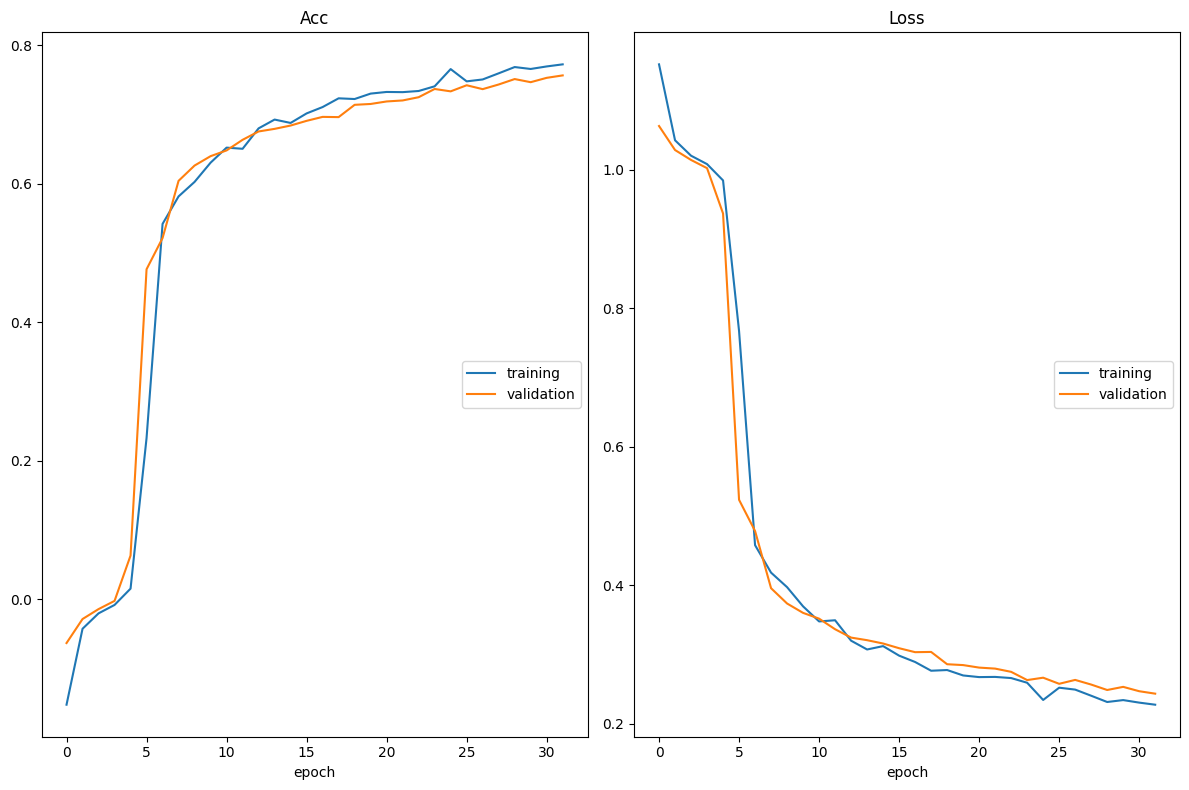

Acc
	training         	 (min:   -0.153, max:    0.772, cur:    0.772)
	validation       	 (min:   -0.064, max:    0.756, cur:    0.756)
Loss
	training         	 (min:    0.228, max:    1.153, cur:    0.228)
	validation       	 (min:    0.244, max:    1.064, cur:    0.244)
EarlyStopping counter: 7 out of 7
Early Stop: Exit Training


aug,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epochs_trained,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
init_lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_after_n_epochs,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_best_model,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
save_weights_only,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sub_points,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_acc,▁▂▂▂▂▄▆▇▇▇▇▇▇▇▇▇████████████████
train_batch_size,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▇▇▅▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


CPU times: user 56min 37s, sys: 11min 32s, total: 1h 8min 9s
Wall time: 1h 17min 13s


In [ ]:
%%time
#main script

if __name__ == '__main__':

  #read the pickle file
  df = pd.read_pickle(sweep_config['parameters']['data_path']['value'])

  #specify the sweep save location
  sweep_config['name'] = datetime.now().strftime('3d-asm-sweep-%Y-%m-%d-%H-%M-%S')
  #set
  sweep_config['parameters']['save_folder']['value'] = sweep_config['parameters']['save_folder']['value'] + sweep_config['name'] + '/'
  #create the sweep folder
  if os.path.isdir(sweep_config['parameters']['save_folder']['value']) == False:
    os.mkdir(sweep_config['parameters']['save_folder']['value'])
  #save the sweep config in the sweep folder
  save_params(sweep_config, sweep_config['parameters']['save_folder']['value'] + 'sweep_config.json')
  #now run the main script

  #select the project folder
  sweep_id = wandb.sweep(sweep_config, project = sweep_config['parameters']['project']['value'])
  #execute the search
  wandb.agent(sweep_id, main)
  #finish
  wandb.finish()

# Inference

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount='True')

Mounted at /content/gdrive


In [ ]:
#install
!pip install --quiet SimpleITK monai transformers einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.9 MB/s eta 0:00:00


In [ ]:
#imports
import SimpleITK as sitk
import monai
import transformers
import einops
import torch
import os
import glob
import pandas as pd
import torch.nn as nn
from transformers import CLIPTextConfig, CLIPTokenizer, CLIPTextModel, AutoTokenizer
import einops
import torch.nn as nn
import torch.nn.functional as F
from typing import Any, Optional, Tuple, Type, List, Dict
from torch import Tensor
import math
import numpy as np
import json


if torch.cuda.is_available():
  device = 'cuda'
  gpu = torch.cuda.get_device_name(0)
  print('Device: ', gpu)
else:
  device = 'cpu'
  gpu = None
  print('Device', device)

Device cpu


In [ ]:
#Image Encoder

# Copyright (c) ImageRx and Anish Salvi.
# All rights reserved.

class LayerNorm3d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        u = x.mean(1, keepdim=True)
        s = (x - u).pow(2).mean(1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.eps)
        x = self.weight[:, None, None, None] * x + self.bias[:, None, None, None]
        return x

class MLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        act: Type[nn.Module] = nn.GELU,
    ) -> None:
        super().__init__()
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.act = act()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.act(self.lin1(x)))


# This class and its supporting functions below lightly adapted from the ViTDet backbone available at: https://github.com/facebookresearch/detectron2/blob/main/detectron2/modeling/backbone/vit.py # noqa
class ImageEncoderViT(nn.Module):
    def __init__(
        self,
        img_size: Tuple[int, int, int] = (64, 64, 64),
        patch_size: Tuple[int, int, int] = (16, 16, 16),
        in_chans: int = 1,
        embed_dim: int = 768, #embed_dim / num_heads = img_size? at least 64, not depth
        depth: int = 12,
        num_heads: int = 12,
        mlp_ratio: float = 4.0,
        out_chans: int = 256,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_abs_pos: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        global_attn_indexes: Tuple[int, ...] = (),
    ) -> None:
        """
        Args:
            img_size (int): Input image size.
            patch_size (int): Patch size.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
            depth (int): Depth of ViT.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_abs_pos (bool): If True, use absolute positional embeddings.
            use_rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks.
            global_attn_indexes (list): Indexes for blocks using global attention.
        """
        super().__init__()

        #store
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_chans = in_chans
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
        self.out_chans = out_chans

        self.patch_embed = PatchEmbed(
            kernel_size = patch_size,
            stride = patch_size,
            in_chans = in_chans,
            embed_dim = embed_dim,
        )

        self.pos_embed: Optional[nn.Parameter] = None
        if use_abs_pos:
            # Initialize absolute positional embedding with pretrain image size.
            self.pos_embed = nn.Parameter(
                torch.zeros(1, img_size[0] // patch_size[0], img_size[1] // patch_size[1], img_size[2] // patch_size[2], embed_dim)
            )

        self.blocks = nn.ModuleList()
        for i in range(depth):
            block = Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                norm_layer=norm_layer,
                act_layer=act_layer,
                use_rel_pos=use_rel_pos,
                rel_pos_zero_init=rel_pos_zero_init,
                window_size=window_size if i not in global_attn_indexes else 0,
                input_size=(img_size[0] // patch_size[0], img_size[1] // patch_size[1], img_size[2] // patch_size[2]),
            )
            self.blocks.append(block)

        self.neck = nn.Sequential(
            nn.Conv3d(
                embed_dim,
                out_chans,
                kernel_size=1,
                bias=False,
            ),
            LayerNorm3d(out_chans),
            nn.Conv3d(
                out_chans,
                out_chans,
                kernel_size=3,
                padding=1,
                bias=False,
            ),
            LayerNorm3d(out_chans),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.patch_embed(x)
        if self.pos_embed is not None:
            x = x + self.pos_embed

        for blk in self.blocks:
            x = blk(x)

        x = self.neck(x.permute(0, 4, 1, 2, 3))

        return x


class Block(nn.Module):
    """Transformer blocks with support of window attention and residual propagation blocks"""

    def __init__(
        self,
        dim: int,
        num_heads: int,
        mlp_ratio: float = 4.0,
        qkv_bias: bool = True,
        norm_layer: Type[nn.Module] = nn.LayerNorm,
        act_layer: Type[nn.Module] = nn.GELU,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        window_size: int = 0,
        input_size: Optional[Tuple[int, int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads in each ViT block.
            mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
            qkv_bias (bool): If True, add a learnable bias to query, key, value.
            norm_layer (nn.Module): Normalization layer.
            act_layer (nn.Module): Activation layer.
            use_rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            window_size (int): Window size for window attention blocks. If it equals 0, then
                use global attention.
            input_size (tuple(int, int, int) or None): Input resolution for calculating the relative
                positional parameter size.
        """
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = AttentionViT(
            dim,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            use_rel_pos=use_rel_pos,
            rel_pos_zero_init=rel_pos_zero_init,
            input_size=input_size if window_size == 0 else (window_size, window_size, window_size),
        )

        self.norm2 = norm_layer(dim)
        self.mlp = MLPBlock(embedding_dim=dim, mlp_dim=int(dim * mlp_ratio), act=act_layer)

        self.window_size = window_size

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        shortcut = x
        x = self.norm1(x)
        # Window partition
        if self.window_size > 0:
            H, W, D = x.shape[1], x.shape[2], x.shape[3]
            x, pad_hwd = window_partition(x, self.window_size)

        x = self.attn(x)
        # Reverse window partition
        if self.window_size > 0:
            x = window_unpartition(x, self.window_size, pad_hwd, (H, W, D))

        x = shortcut + x
        x = x + self.mlp(self.norm2(x))

        return x


class AttentionViT(nn.Module):
    """Multi-head Attention block with relative position embeddings."""

    def __init__(
        self,
        dim: int,
        num_heads: int = 8,
        qkv_bias: bool = True,
        use_rel_pos: bool = False,
        rel_pos_zero_init: bool = True,
        input_size: Optional[Tuple[int, int, int]] = None,
    ) -> None:
        """
        Args:
            dim (int): Number of input channels.
            num_heads (int): Number of attention heads.
            qkv_bias (bool):  If True, add a learnable bias to query, key, value.
            rel_pos (bool): If True, add relative positional embeddings to the attention map.
            rel_pos_zero_init (bool): If True, zero initialize relative positional parameters.
            input_size (tuple(int, int) or None): Input resolution for calculating the relative
                positional parameter size.
        """
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim**-0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

        self.use_rel_pos = use_rel_pos
        if self.use_rel_pos:
            assert (
                input_size is not None
            ), "Input size must be provided if using relative positional encoding."
            # initialize relative positional embeddings
            self.rel_pos_h = nn.Parameter(torch.zeros(2 * input_size[0] - 1, head_dim))
            self.rel_pos_w = nn.Parameter(torch.zeros(2 * input_size[1] - 1, head_dim))
            self.rel_pos_d = nn.Parameter(torch.zeros(2 * input_size[2] - 1, head_dim))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, H, W, D, _ = x.shape
        # qkv with shape (3, B, nHead, H * W * D, C)
        qkv = self.qkv(x).reshape(B, H * W * D, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        # q, k, v with shape (B * nHead, H * W * D, C)
        q, k, v = qkv.reshape(3, B * self.num_heads, H * W * D, -1).unbind(0)

        attn = (q * self.scale) @ k.transpose(-2, -1)

        if self.use_rel_pos:
            attn = add_decomposed_rel_pos(attn, q, self.rel_pos_h, self.rel_pos_w, self.rel_pos_d, (H, W, D), (H, W, D))

        attn = attn.softmax(dim=-1)
        x = (attn @ v).view(B, self.num_heads, H, W, D, -1).permute(0, 2, 3, 4, 1, 5).reshape(B, H, W, D, -1)
        x = self.proj(x)

        return x


def window_partition(x: torch.Tensor, window_size: int) -> Tuple[torch.Tensor, Tuple[int, int, int]]:
    """
    Partition into non-overlapping windows with padding if needed.
    Args:
        x (tensor): input tokens with [B, C, H, W, D].
        window_size (int): window size.

    Returns:
        windows: windows after partition with [B * num_windows, window_size, window_size, window_size, C].
        (Hp, Wp, Dp): padded height and width before partition
    """
    B, C, H, W, D = x.shape

    pad_h = (window_size - H % window_size) % window_size
    pad_w = (window_size - W % window_size) % window_size
    pad_d = (window_size - D % window_size) % window_size
    if pad_h > 0 or pad_w > 0 or pad_d > 0:
        x = F.pad(x, (0, 0, 0, pad_w, 0, pad_h, 0, pad_d))
    Hp, Wp, Dp = H + pad_h, W + pad_w, D + pad_d

    x = x.view(B, Hp // window_size, window_size, Wp // window_size, window_size, Dp // window_size, window_size, C)
    windows = x.contiguous().view(-1, window_size, window_size, window_size, C) #permute removed
    return windows, (Hp, Wp, Dp)


def window_unpartition(
    windows: torch.Tensor, window_size: int, pad_hwd: Tuple[int, int, int], hwd: Tuple[int, int, int]
) -> torch.Tensor:
    """
    Window unpartition into original sequences and removing padding.
    Args:
        windows (tensor): input tokens with [B * num_windows, window_size, window_size, window_size, C].
        window_size (int): window size.
        pad_hwd (Tuple): padded height and width (Hp, Wp, Dp).
        hwd (Tuple): original height and width (H, W, D) before padding.

    Returns:
        x: unpartitioned sequences with [B, C, H, W, D].
    """
    Hp, Wp, Dp = pad_hwd
    H, W, D = hwd
    B = windows.shape[0] // (Hp * Wp * Dp // window_size // window_size // window_size)
    x = windows.view(B, Hp // window_size, Wp // window_size, Dp // window_size, window_size, window_size, window_size, -1)
    x = x.contiguous().view(B, Hp, Wp, Dp, -1) #permute removed

    if Hp > H or Wp > W or Dp > D:
        x = x[:, :H, :W, :D, :].contiguous()
    return x


def get_rel_pos(q_size: int, k_size: int, rel_pos: torch.Tensor) -> torch.Tensor:
    """
    Get relative positional embeddings according to the relative positions of
        query and key sizes.
    Args:
        q_size (int): size of query q.
        k_size (int): size of key k.
        rel_pos (Tensor): relative position embeddings (L, C).

    Returns:
        Extracted positional embeddings according to relative positions.
    """
    max_rel_dist = int(2 * max(q_size, k_size) - 1)
    # Interpolate rel pos if needed.
    if rel_pos.shape[0] != max_rel_dist:
        # Interpolate rel pos.
        rel_pos_resized = F.interpolate(
            rel_pos.reshape(1, rel_pos.shape[0], -1).permute(0, 2, 1),
            size=max_rel_dist,
            mode="linear",
        )
        rel_pos_resized = rel_pos_resized.reshape(-1, max_rel_dist).permute(1, 0)
    else:
        rel_pos_resized = rel_pos

    # Scale the coords with short length if shapes for q and k are different.
    q_coords = torch.arange(q_size)[:, None] * max(k_size / q_size, 1.0)
    k_coords = torch.arange(k_size)[None, :] * max(q_size / k_size, 1.0)
    relative_coords = (q_coords - k_coords) + (k_size - 1) * max(q_size / k_size, 1.0)

    return rel_pos_resized[relative_coords.long()]


def add_decomposed_rel_pos(
    attn: torch.Tensor,
    q: torch.Tensor,
    rel_pos_h: torch.Tensor,
    rel_pos_w: torch.Tensor,
    rel_pos_d: torch.Tensor,
    q_size: Tuple[int, int, int],
    k_size: Tuple[int, int, int],
) -> torch.Tensor:
    """
    Calculate decomposed Relative Positional Embeddings from :paper:`mvitv2`.
    https://github.com/facebookresearch/mvit/blob/19786631e330df9f3622e5402b4a419a263a2c80/mvit/models/attention.py   # noqa B950
    Args:
        attn (Tensor): attention map.
        q (Tensor): query q in the attention layer with shape (B, q_h * q_w * q_d, C).
        rel_pos_h (Tensor): relative position embeddings (Lh, C) for height axis.
        rel_pos_w (Tensor): relative position embeddings (Lw, C) for width axis.
        rel_pos_d (Tensor): relative position embeddings (Ld, C) for depth axis.
        q_size (Tuple): spatial sequence size of query q with (q_h, q_w, q_d).
        k_size (Tuple): spatial sequence size of key k with (k_h, k_w, k_d).

    Returns:
        attn (Tensor): attention map with added relative positional embeddings.
    """
    q_h, q_w, q_d = q_size
    k_h, k_w, k_d = k_size

    Rh = get_rel_pos(q_h, k_h, rel_pos_h)
    Rw = get_rel_pos(q_w, k_w, rel_pos_w)
    Rd = get_rel_pos(q_d, k_d, rel_pos_d)

    B, _, dim = q.shape
    r_q = q.reshape(B, q_h, q_w, q_d, dim)
    rel_h = torch.einsum("bhwdc,hkc->bhwdk", r_q, Rh)
    rel_w = torch.einsum("bhwdc,wkc->bhwdk", r_q, Rw)
    rel_d = torch.einsum("bhwdc,dkc->bhwdk", r_q, Rd)

    attn = (
        attn.view(B, q_h, q_w, q_d, k_h, k_w, k_d)
        + rel_h[:, :, :, :, :, None] + rel_w[:, :, :, :, None, :] + rel_d[:, :, :, None, :, :]
        ).view(B, q_h * q_w * q_d, k_h * k_w * k_d)

    return attn

class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding.
    """

    def __init__(
        self,
        kernel_size: Tuple[int, int, int] = (16, 16, 16),
        stride: Tuple[int, int, int] = (16, 16, 16),
        padding: Tuple[int, int, int] = (0, 0, 0),
        in_chans: int = 1,
        embed_dim: int = 768,
    ) -> None:
        """
        Args:
            kernel_size (Tuple): kernel size of the projection layer.
            stride (Tuple): stride of the projection layer.
            padding (Tuple): padding size of the projection layer.
            in_chans (int): Number of input image channels.
            embed_dim (int): Patch embedding dimension.
        """
        super().__init__()

        self.proj = nn.Conv3d(
            in_chans, embed_dim, kernel_size=kernel_size, stride=stride, padding=padding
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.proj(x)
        # B C H W D -> B H W D C
        x = x.permute(0, 2, 3, 4, 1)
        return x

In [ ]:
#Prompt Encoder

# Copyright (c) ImageRx and Anish Salvi.
# All rights reserved.

def divide(test_tup1, test_tup2):
  return tuple(ele1 // ele2 for ele1, ele2 in zip(test_tup1, test_tup2))

def get_down_scaling(kernel_stride_size, mask_in_chans, embed_dim):
      max_downscaling = nn.Sequential()
      #iterate
      for i in range(len(kernel_stride_size)):
        max_downscaling.add_module("conv_" + str(i), nn.Conv3d(mask_in_chans[i], mask_in_chans[i + 1],
                                                           kernel_size = kernel_stride_size[i], stride = kernel_stride_size[i]))
        max_downscaling.add_module("norm_" + str(i), LayerNorm3d(mask_in_chans[i + 1]))
        max_downscaling.add_module("act_" + str(i), torch.nn.GELU())
      max_downscaling.add_module("embed_" + str(0), torch.nn.Conv3d(mask_in_chans[i + 1], embed_dim, kernel_size=1))
      #return
      return max_downscaling


class PromptEncoder(nn.Module):
    def __init__(
        self,
        embed_dim: int,
        input_image_size: Tuple[int, int, int],
        patch_size: Tuple[int, int, int],
        mask_in_chans: List,
        kernel_stride_size: List,
        num_attention_heads: int,
        num_hidden_layers: int,
        projection_dim: int,
        intermediate_size: int,
        max_position_embeddings: int,
        activation: Type[nn.Module] = nn.GELU,
        tokenizer: Optional[AutoTokenizer] = None
    ) -> None:
        """
        Encodes prompts for input to SAM's mask decoder.

        Arguments:
          embed_dim (int): The prompts' embedding dimension
          input_image_size (int): The padded size of the image as input
            to the image encoder, as (H, W, D).
          patch_size (tuple(int, int, int)): The spatial size of the
            image embedding, as (H, W, D).
          mask_in_chans (int): The number of hidden channels used for
            encoding input masks.
          activation (nn.Module): The activation to use when encoding
            input masks.
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.input_image_size = input_image_size
        self.pe_layer = PositionEmbeddingRandom(embed_dim // 2)

        self.num_point_embeddings: int = 4  # pos/neg point + 2 box corners
        point_embeddings = [nn.Embedding(1, embed_dim) for i in range(self.num_point_embeddings)]
        self.point_embeddings = nn.ModuleList(point_embeddings)
        self.not_a_point_embed = nn.Embedding(1, embed_dim)
        self.image_embedding_size = divide(self.input_image_size, patch_size)

        #might need deeper network?
        self.mask_downscaling = get_down_scaling(kernel_stride_size, mask_in_chans, embed_dim)
        self.no_mask_embed = nn.Embedding(1, embed_dim)

        #init
        path = "openai/clip-vit-base-patch32"
        #get config
        config = CLIPTextConfig.from_pretrained(path)
        #if
        if tokenizer is None:
          #get tokenizer
          self.tokenizer = CLIPTokenizer.from_pretrained(path)
          #set
          config.bos_token_id = self.tokenizer.bos_token_id
          config.eos_token_id = self.tokenizer.eos_token_id
        else:
          #get tokenizer
          self.tokenizer = tokenizer
          #set
          config.bos_token_id = self.tokenizer.bos_token_id
          config.eos_token_id = self.tokenizer.eos_token_id
        #set
        config.num_attention_heads = num_attention_heads
        config.num_hidden_layers = num_hidden_layers
        config.projection_dim = projection_dim
        config.intermediate_size = intermediate_size
        config.max_position_embeddings = max_position_embeddings
        #set hidden state
        config.hidden_size = embed_dim
        #model
        self.text_model = CLIPTextModel(config)

    def get_dense_pe(self) -> torch.Tensor:
        """
        Returns the positional encoding used to encode point prompts,
        applied to a dense set of points the shape of the image encoding.

        Returns:
          torch.Tensor: Positional encoding with shape
            1x(embed_dim)x(embedding_h)x(embedding_w)x(embedding_d)
        """
        return self.pe_layer(self.image_embedding_size).unsqueeze(0)

    def _embed_points(
        self,
        points: torch.Tensor,
        labels: torch.Tensor,
        pad: bool,
    ) -> torch.Tensor:
        """Embeds point prompts."""
        points = points + 0.5  # Shift to center of pixel
        if pad:
            padding_point = torch.zeros((points.shape[0], 1, 3), device=points.device)
            padding_label = -torch.ones((labels.shape[0], 1), device=labels.device)
            points = torch.cat([points, padding_point], dim=1)
            labels = torch.cat([labels, padding_label], dim=1)
        point_embedding = self.pe_layer.forward_with_coords(points, self.input_image_size)
        point_embedding[labels == -1] = 0.0
        point_embedding[labels == -1] += self.not_a_point_embed.weight
        point_embedding[labels == 0] += self.point_embeddings[0].weight
        point_embedding[labels == 1] += self.point_embeddings[1].weight
        return point_embedding

    def _embed_boxes(self, boxes: torch.Tensor) -> torch.Tensor:
        """Embeds box prompts."""
        boxes = boxes + 0.5  # Shift to center of pixel
        coords = boxes.reshape(-1, 2, 3)
        corner_embedding = self.pe_layer.forward_with_coords(coords, self.input_image_size)
        corner_embedding[:, 0, :] += self.point_embeddings[2].weight
        corner_embedding[:, 1, :] += self.point_embeddings[3].weight
        return corner_embedding

    def _embed_masks(self, masks: torch.Tensor) -> torch.Tensor:
        """Embeds mask inputs."""
        mask_embedding = self.mask_downscaling(masks)
        return mask_embedding

    def _embed_text(self, text):
        """Embeds text inputs."""
        inputs = self.tokenizer(text, padding=True, return_tensors="pt").to(self._get_device())
        outputs = self.text_model(**inputs)
        return outputs.pooler_output[:, None, :]

    def _get_batch_size(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
        text: Optional[List]
    ) -> int:
        """
        Gets the batch size of the output given the batch size of the input prompts.
        """
        if points[0] is not None:
          return points[0].shape[0]
        elif boxes is not None:
          return boxes.shape[0]
        elif text is not None:
          return len(text)
        elif masks is not None:
          return masks.shape[0]
        else:
          return 1

    def _get_device(self) -> torch.device:
        return self.point_embeddings[0].weight.device

    def forward(
        self,
        points: Optional[Tuple[torch.Tensor, torch.Tensor]],
        boxes: Optional[torch.Tensor],
        masks: Optional[torch.Tensor],
        text: Optional[List],
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Embeds different types of prompts, returning both sparse and dense
        embeddings.

        Arguments:
          points (tuple(torch.Tensor, torch.Tensor) or none): point coordinates
            and labels to embed.
          boxes (torch.Tensor or none): boxes to embed
          masks (torch.Tensor or none): masks to embed
          text  (list): text to embed

        Returns:
          torch.Tensor: sparse embeddings for the points and boxes, with shape
            BxNx(embed_dim), where N is determined by the number of input points
            and boxes.
          torch.Tensor: dense embeddings for the masks, in the shape
            Bx(embed_dim)x(embed_H)x(embed_W)x(embed_D)
        """
        bs = self._get_batch_size(points, boxes, masks, text)
        sparse_embeddings = torch.empty((bs, 0, self.embed_dim), device=self._get_device())
        if points[0] is not None:
            coords, labels = points
            point_embeddings = self._embed_points(coords, labels, pad=(boxes is None))
            sparse_embeddings = torch.cat([sparse_embeddings, point_embeddings], dim=1)
        if boxes is not None:
            box_embeddings = self._embed_boxes(boxes)
            sparse_embeddings = torch.cat([sparse_embeddings, box_embeddings], dim=1)
        if text is not None:
            text_embeddings = self._embed_text(text)
            sparse_embeddings = torch.cat([sparse_embeddings, text_embeddings], dim=1)
        if masks is not None:
            dense_embeddings = self._embed_masks(masks)
        else:
            dense_embeddings = self.no_mask_embed.weight.reshape(1, -1, 1, 1, 1).expand(
                bs, -1, self.image_embedding_size[0], self.image_embedding_size[1], self.image_embedding_size[2]
                )

        return sparse_embeddings, dense_embeddings


class PositionEmbeddingRandom(nn.Module):
    """
    Positional encoding using random spatial frequencies.
    """

    def __init__(self, num_pos_feats: int = 64, scale: Optional[float] = None) -> None:
        super().__init__()
        if scale is None or scale <= 0.0:
            scale = 1.0
        self.register_buffer(
            "positional_encoding_gaussian_matrix",
            scale * torch.randn((3, num_pos_feats)),
        )

    def _pe_encoding(self, coords: torch.Tensor) -> torch.Tensor:
        """Positionally encode points that are normalized to [0,1]."""
        # assuming coords are in [0, 1]^2 square and have d_1 x ... x d_n x 2 shape
        coords = 2 * coords - 1
        coords = coords @ self.positional_encoding_gaussian_matrix
        coords = 2 * np.pi * coords
        # outputs d_1 x ... x d_n x C shape
        return torch.cat([torch.sin(coords), torch.cos(coords)], dim=-1)

    def forward(self, size: Tuple[int, int, int]) -> torch.Tensor:
        """Generate positional encoding for a grid of the specified size."""
        h, w, d = size
        device: Any = self.positional_encoding_gaussian_matrix.device
        grid = torch.ones((h, w, d), device=device, dtype=torch.float32)
        #embed
        x_embed = grid.cumsum(dim=0) - 0.5
        y_embed = grid.cumsum(dim=1) - 0.5
        z_embed = grid.cumsum(dim=2) - 0.5
        #norm
        x_embed = x_embed / h
        y_embed = y_embed / w
        z_embed = z_embed / d
        #encode
        pe = self._pe_encoding(torch.stack([x_embed, y_embed, z_embed], dim=-1))
        return pe.permute(3, 0, 1, 2)  # C x H x W x D

    def forward_with_coords(
        self, coords_input: torch.Tensor, image_size: Tuple[int, int, int]
    ) -> torch.Tensor:
        """Positionally encode points that are not normalized to [0,1]."""
        coords = coords_input.clone()
        coords[:, :, 0] = coords[:, :, 0] / image_size[0]
        coords[:, :, 1] = coords[:, :, 1] / image_size[1]
        coords[:, :, 2] = coords[:, :, 2] / image_size[2]
        return self._pe_encoding(coords.to(torch.float))  # B x N x C

In [ ]:
#Transformer

# Copyright (c) ImageRx and Anish Salvi.
# All rights reserved.

class TwoWayTransformerMLPBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        mlp_dim: int,
        act: Type[nn.Module] = nn.GELU,
    ) -> None:
        super().__init__()
        self.lin1 = nn.Linear(embedding_dim, mlp_dim)
        self.lin2 = nn.Linear(mlp_dim, embedding_dim)
        self.act = act()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.lin2(self.act(self.lin1(x)))


class TwoWayTransformer(nn.Module):
    def __init__(
        self,
        depth: int,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 2,
    ) -> None:
        """
        A transformer decoder that attends to an input image using
        queries whose positional embedding is supplied.

        Args:
          depth (int): number of layers in the transformer
          embedding_dim (int): the channel dimension for the input embeddings
          num_heads (int): the number of heads for multihead attention. Must
            divide embedding_dim
          mlp_dim (int): the channel dimension internal to the MLP block
          activation (nn.Module): the activation to use in the MLP block
        """
        super().__init__()
        self.depth = depth
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.layers = nn.ModuleList()

        for i in range(depth):
            self.layers.append(
                TwoWayAttentionBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_dim=mlp_dim,
                    activation=activation,
                    attention_downsample_rate=attention_downsample_rate,
                    skip_first_layer_pe=(i == 0),
                )
            )

        self.final_attn_token_to_image = TwoWayTransformerAttention(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )
        self.norm_final_attn = nn.LayerNorm(embedding_dim)

    def forward(
        self,
        image_embedding: Tensor,
        image_pe: Tensor,
        point_embedding: Tensor,
    ) -> Tuple[Tensor, Tensor]:
        """
        Args:
          image_embedding (torch.Tensor): image to attend to. Should be shape
            B x embedding_dim x h x w x d for any h and w and d.
          image_pe (torch.Tensor): the positional encoding to add to the image. Must
            have the same shape as image_embedding.
          point_embedding (torch.Tensor): the embedding to add to the query points.
            Must have shape B x N_points x embedding_dim for any N_points.

        Returns:
          torch.Tensor: the processed point_embedding
          torch.Tensor: the processed image_embedding
        """
        # BxCxHxW -> BxHWxC == B x N_image_tokens x C
        #bs, c, h, w, d = image_embedding.shape
        image_embedding = image_embedding.flatten(2).permute(0, 2, 1)
        image_pe = image_pe.flatten(2).permute(0, 2, 1)

        # Prepare queries
        queries = point_embedding
        keys = image_embedding

        # Apply transformer blocks and final layernorm
        for layer in self.layers:
            queries, keys = layer(
                queries=queries,
                keys=keys,
                query_pe=point_embedding,
                key_pe=image_pe,
            )

        # Apply the final attention layer from the points to the image
        q = queries + point_embedding
        k = keys + image_pe
        attn_out = self.final_attn_token_to_image(q=q, k=k, v=keys)
        queries = queries + attn_out
        queries = self.norm_final_attn(queries)

        return queries, keys


class TwoWayAttentionBlock(nn.Module):
    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        mlp_dim: int = 2048,
        activation: Type[nn.Module] = nn.ReLU,
        attention_downsample_rate: int = 2,
        skip_first_layer_pe: bool = False,
    ) -> None:
        """
        A transformer block with four layers: (1) self-attention of sparse
        inputs, (2) cross attention of sparse inputs to dense inputs, (3) mlp
        block on sparse inputs, and (4) cross attention of dense inputs to sparse
        inputs.

        Arguments:
          embedding_dim (int): the channel dimension of the embeddings
          num_heads (int): the number of heads in the attention layers
          mlp_dim (int): the hidden dimension of the mlp block
          activation (nn.Module): the activation of the mlp block
          skip_first_layer_pe (bool): skip the PE on the first layer
        """
        super().__init__()
        self.self_attn = TwoWayTransformerAttention(embedding_dim, num_heads)
        self.norm1 = nn.LayerNorm(embedding_dim)

        self.cross_attn_token_to_image = TwoWayTransformerAttention(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )
        self.norm2 = nn.LayerNorm(embedding_dim)

        self.mlp = TwoWayTransformerMLPBlock(embedding_dim, mlp_dim, activation)
        self.norm3 = nn.LayerNorm(embedding_dim)

        self.norm4 = nn.LayerNorm(embedding_dim)
        self.cross_attn_image_to_token = TwoWayTransformerAttention(
            embedding_dim, num_heads, downsample_rate=attention_downsample_rate
        )

        self.skip_first_layer_pe = skip_first_layer_pe

    def forward(
        self, queries: Tensor, keys: Tensor, query_pe: Tensor, key_pe: Tensor
    ) -> Tuple[Tensor, Tensor]:
        # Self attention block
        if self.skip_first_layer_pe:
            queries = self.self_attn(q=queries, k=queries, v=queries)
        else:
            q = queries + query_pe
            attn_out = self.self_attn(q=q, k=q, v=queries)
            queries = queries + attn_out
        queries = self.norm1(queries)

        # Cross attention block, tokens attending to image embedding
        q = queries + query_pe
        k = keys + key_pe
        attn_out = self.cross_attn_token_to_image(q=q, k=k, v=keys)
        queries = queries + attn_out
        queries = self.norm2(queries)

        # MLP block
        mlp_out = self.mlp(queries)
        queries = queries + mlp_out
        queries = self.norm3(queries)

        # Cross attention block, image embedding attending to tokens
        q = queries + query_pe
        k = keys + key_pe
        attn_out = self.cross_attn_image_to_token(q=k, k=q, v=queries)
        keys = keys + attn_out
        keys = self.norm4(keys)

        return queries, keys


class TwoWayTransformerAttention(nn.Module):
    """
    An attention layer that allows for downscaling the size of the embedding
    after projection to queries, keys, and values.
    """

    def __init__(
        self,
        embedding_dim: int,
        num_heads: int,
        downsample_rate: int = 1,
    ) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.internal_dim = embedding_dim // downsample_rate
        self.num_heads = num_heads
        assert self.internal_dim % num_heads == 0, "num_heads must divide embedding_dim."

        self.q_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.k_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.v_proj = nn.Linear(embedding_dim, self.internal_dim)
        self.out_proj = nn.Linear(self.internal_dim, embedding_dim)

    def _separate_heads(self, x: Tensor, num_heads: int) -> Tensor:
        b, n, c = x.shape
        x = x.reshape(b, n, num_heads, c // num_heads)
        return x.transpose(1, 2)  # B x N_heads x N_tokens x C_per_head

    def _recombine_heads(self, x: Tensor) -> Tensor:
        b, n_heads, n_tokens, c_per_head = x.shape
        x = x.transpose(1, 2)
        return x.reshape(b, n_tokens, n_heads * c_per_head)  # B x N_tokens x C

    def forward(self, q: Tensor, k: Tensor, v: Tensor) -> Tensor:
        # Input projections
        q = self.q_proj(q)
        k = self.k_proj(k)
        v = self.v_proj(v)

        # Separate into heads
        q = self._separate_heads(q, self.num_heads)
        k = self._separate_heads(k, self.num_heads)
        v = self._separate_heads(v, self.num_heads)

        # Attention
        _, _, _, c_per_head = q.shape
        attn = q @ k.permute(0, 1, 3, 2)  # B x N_heads x N_tokens x N_tokens
        attn = attn / math.sqrt(c_per_head)
        attn = torch.softmax(attn, dim=-1)

        # Get output
        out = attn @ v
        out = self._recombine_heads(out)
        out = self.out_proj(out)

        return out

In [ ]:
#Mask Decoder

# Copyright (c) ImageRx and Anish Salvi.
# All rights reserved.

def get_output_scaling(kernel_stride_size, transformer_dim):
      output_upscaling = nn.Sequential()
      #iterate
      for i in range(len(kernel_stride_size)):
        output_upscaling.add_module("conv_" + str(i), nn.ConvTranspose3d(transformer_dim[i], transformer_dim[i+1],
                                                                         kernel_size = kernel_stride_size[i], stride = kernel_stride_size[i]))
        if len(kernel_stride_size) - 1 == i:
          output_upscaling.add_module("act_" + str(i), torch.nn.GELU())
          continue
        else:
          output_upscaling.add_module("norm_" + str(i), LayerNorm3d(transformer_dim[i + 1]))
          output_upscaling.add_module("act_" + str(i), torch.nn.GELU())
      #return
      return output_upscaling

def get_MLP(start_dim, end_dim, num_mask_tokens, num_layers):
  output_hypernetworks_mlps = nn.ModuleList([
      MLP(start_dim, start_dim, end_dim, num_layers)
      for i in range(num_mask_tokens)
      ])
  return output_hypernetworks_mlps


class MaskDecoder(nn.Module):
    def __init__(
        self,
        kernel_stride_size: List,
        transformer_dim: List,
        patch_size: Tuple[int, int, int],
        transformer: nn.Module,
        num_multimask_outputs: int = 3,
        activation: Type[nn.Module] = nn.GELU,
        iou_head_depth: int = 3,
        iou_head_hidden_dim: int = 256,
        num_layers: int = 3
    ) -> None:
        """
        Predicts masks given an image and prompt embeddings, using a
        transformer architecture.

        Arguments:
          transformer_dim (int): the channel dimension of the transformer
          patch_size Tuple(int, int, int): the patch size used in the encoder
          transformer (nn.Module): the transformer used to predict masks
          num_multimask_outputs (int): the number of masks to predict
            when disambiguating masks
          activation (nn.Module): the type of activation to use when
            upscaling masks
          iou_head_depth (int): the depth of the MLP used to predict
            mask quality
          iou_head_hidden_dim (int): the hidden dimension of the MLP
            used to predict mask quality
        """
        super().__init__()
        self.transformer = transformer
        self.num_multimask_outputs = num_multimask_outputs

        self.iou_token = nn.Embedding(1, transformer_dim[0])
        self.num_mask_tokens = num_multimask_outputs + 1
        self.mask_tokens = nn.Embedding(self.num_mask_tokens, transformer_dim[0])
        self.patch_size = patch_size

        self.output_upscaling = get_output_scaling(kernel_stride_size, transformer_dim)
        self.output_hypernetworks_mlps = get_MLP(transformer_dim[0], transformer_dim[-1], self.num_mask_tokens, num_layers)

        self.iou_prediction_head = MLP(
            transformer_dim[0], iou_head_hidden_dim, self.num_mask_tokens, iou_head_depth
        )

    def forward(
        self,
        image_embeddings: torch.Tensor,
        image_pe: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: torch.Tensor,
        multimask_output: bool,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predict masks given image and prompt embeddings.

        Arguments:
          image_embeddings (torch.Tensor): the embeddings from the image encoder
          image_pe (torch.Tensor): positional encoding with the shape of image_embeddings
          sparse_prompt_embeddings (torch.Tensor): the embeddings of the points and boxes
          dense_prompt_embeddings (torch.Tensor): the embeddings of the mask inputs
          multimask_output (bool): Whether to return multiple masks or a single
            mask.

        Returns:
          torch.Tensor: batched predicted masks
          torch.Tensor: batched predictions of mask quality
        """
        masks, iou_pred = self.predict_masks(
            image_embeddings=image_embeddings,
            image_pe=image_pe,
            sparse_prompt_embeddings=sparse_prompt_embeddings,
            dense_prompt_embeddings=dense_prompt_embeddings,
        )

        # Select the correct mask or masks for output
        if multimask_output:
            mask_slice = slice(1, None)
        else:
            mask_slice = slice(0, 1)
        masks = masks[:, mask_slice, :, :, :]
        iou_pred = iou_pred[:, mask_slice]

        # Prepare output
        return masks, iou_pred

    def predict_masks(
        self,
        image_embeddings: torch.Tensor,
        image_pe: torch.Tensor,
        sparse_prompt_embeddings: torch.Tensor,
        dense_prompt_embeddings: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """Predicts masks. See 'forward' for more details."""
        # Concatenate output tokens
        output_tokens = torch.cat([self.iou_token.weight, self.mask_tokens.weight], dim=0)
        output_tokens = output_tokens.unsqueeze(0).expand(sparse_prompt_embeddings.size(0), -1, -1)
        tokens = torch.cat((output_tokens, sparse_prompt_embeddings), dim=1)

        # Expand per-image data in batch direction to be per-mask
        src = torch.repeat_interleave(image_embeddings, tokens.shape[0], dim=0)
        src = src + dense_prompt_embeddings
        pos_src = torch.repeat_interleave(image_pe, tokens.shape[0], dim=0)
        b, c, h, w, d = src.shape

        # Run the transformer
        hs, src = self.transformer(src, pos_src, tokens)
        iou_token_out = hs[:, 0, :]
        mask_tokens_out = hs[:, 1 : (1 + self.num_mask_tokens), :]

        # Upscale mask embeddings and predict masks using the mask tokens
        src = src.transpose(1, 2).view(b, c, h, w, d)
        upscaled_embedding = self.output_upscaling(src)
        hyper_in_list: List[torch.Tensor] = []
        #iterate
        for i in range(self.num_mask_tokens):
            hyper_in_list.append(self.output_hypernetworks_mlps[i](mask_tokens_out[:, i, :]))
        hyper_in = torch.stack(hyper_in_list, dim=1)
        #b, c, h, w = upscaled_embedding.shape this is likely if the upscaled embedding does not have the same size if altering upsampling
        b, c, h, w, d = upscaled_embedding.shape
        masks = (hyper_in @ upscaled_embedding.view(b, c, h * w * d)).view(b, -1, h, w, d)

        # Generate mask quality predictions
        iou_pred = self.iou_prediction_head(iou_token_out)

        return masks, iou_pred


# Lightly adapted from
# https://github.com/facebookresearch/MaskFormer/blob/main/mask_former/modeling/transformer/transformer_predictor.py # noqa
class MLP(nn.Module):
    def __init__(
        self,
        input_dim: int,
        hidden_dim: int,
        output_dim: int,
        num_layers: int,
        sigmoid_output: bool = False,
    ) -> None:
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(
            nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim])
        )
        self.sigmoid_output = sigmoid_output

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        if self.sigmoid_output:
            x = F.sigmoid(x)
        return x

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

class AnishSalviModel(nn.Module):

    def __init__(
        self,
        img_size: Tuple[int, int, int] = (64, 64, 64),
        patch_size: Tuple[int, int, int] = (8, 8, 8),
        in_chans: int = 1,
        image_embed_dim: int = 768, #has to be 768?
        image_encoder_depth: int = 12,
        image_encoder_num_heads: int = 12,
        image_encoder_mlp_ratio: int = 4,
        image_encoder_out_chans: int = 512, #same?
        prompt_encoder_embed_dim: int = 512, #same?
        prompt_encoder_mask_in_chans: List = [1, 3, 5],
        prompt_encoder_kernel_stride_size: List = [(2, 2, 2), (4, 4, 4)],
        prompt_encoder_num_attention_heads: int = 4,
        prompt_encoder_num_hidden_layers: int = 12,
        prompt_encoder_projection_dim: int = 64,
        prompt_encoder_intermediate_size: int = 64,
        prompt_encoder_max_position_embeddings: int = 10,
        transformer_depth: int = 16,
        transformer_embedding_dim: int = 512, #same?
        transformer_num_heads: int = 16,
        transformer_mlp_dim: int = 8,
        mask_decoder_kernel_stride_size: List = [(4, 4, 4), (2, 2, 2)],
        mask_decoder_transformer_dim: List = [512, 512, 512],
        mask_decoder_num_multimask_outputs: int = 3,
        mask_decoder_num_layers: int = 3,
        tokenizer: Optional[AutoTokenizer] = None
    ) -> None:
        """
        SAM predicts object masks from an image and input prompts.

        Arguments:
          image_encoder (ImageEncoderViT): The backbone used to encode the
            image into image embeddings that allow for efficient mask prediction.
          prompt_encoder (PromptEncoder): Encodes various types of input prompts.
          transformer (TwoWayTransformer): Processes embeddings within mask_decoder
          mask_decoder (MaskDecoder): Predicts masks from the image embeddings
            and encoded prompts.
        """
        super().__init__()
        #image encoder
        self.image_encoder = ImageEncoderViT(img_size, patch_size, in_chans, image_embed_dim,
                                image_encoder_depth, image_encoder_num_heads, image_encoder_mlp_ratio, image_encoder_out_chans)

        #prompt encoder
        self.prompt_encoder = PromptEncoder(prompt_encoder_embed_dim,
                                            img_size, patch_size, prompt_encoder_mask_in_chans, prompt_encoder_kernel_stride_size,
                                            prompt_encoder_num_attention_heads,
                                            prompt_encoder_num_hidden_layers, prompt_encoder_projection_dim,
                                            prompt_encoder_intermediate_size, prompt_encoder_max_position_embeddings, tokenizer)
        #transformer
        transformer = TwoWayTransformer(transformer_depth, transformer_embedding_dim,
                                        transformer_num_heads, transformer_mlp_dim)
        #mask decoder
        self.mask_decoder = MaskDecoder(mask_decoder_kernel_stride_size, mask_decoder_transformer_dim, patch_size, transformer,
                                        mask_decoder_num_multimask_outputs, mask_decoder_num_layers)

    def forward(
        self,
        batched_input: List[Dict[str, Any]],
        multimask_output: bool,
    ) -> List[Dict[str, torch.Tensor]]:
        """
        Predicts masks end-to-end from provided images and prompts.
        If prompts are not known in advance, using ASMpredictor is
        recommended over calling the model directly.

        Arguments:
          batched_input (list(dict)): A list over input images, each a
            dictionary with the following keys. A prompt key can be
            excluded if it is not present.
              'image': The image as a torch tensor in CxHxWxD format,
                already transformed for input to the model.
              'point_coords': (torch.Tensor) Batched point prompts for
                this image, with shape BxNx3. Already transformed to the
                input frame of the model.
              'point_labels': (torch.Tensor) Batched labels for point prompts,
                with shape BxN.
              'boxes': (torch.Tensor) Batched box inputs, with shape Bx6.
                Already transformed to the input frame of the model.
              'mask_inputs': (torch.Tensor) Batched mask inputs to the model,
                in the form Bx1xHxWxD.
          multimask_output (bool): Whether the model should predict multiple
            disambiguating masks, or return a single mask.

        Returns:
          (list(dict)): A list over input images, where each element is
            as dictionary with the following keys.
              'iou_predictions': (torch.Tensor) The model's predictions
                of mask quality, in shape BxC.
              'low_res_logits': (torch.Tensor) Low resolution logits with
                shape BxCxHxW. Can be passed as mask input
                to subsequent iterations of prediction.
        """
        input_images = torch.stack([x["image"] for x in batched_input], dim=0)
        image_embeddings = self.image_encoder(input_images)

        outputs = []
        for image_record, curr_embedding in zip(batched_input, image_embeddings):
            #encode embeddings
            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=(image_record["point_coords"], image_record["point_labels"]),
                boxes=image_record.get("boxes", None),
                masks=image_record.get("mask_inputs", None),
                text=image_record.get("text", None)
            )
            #decode embeddings
            low_res_masks, iou_predictions = self.mask_decoder(
                image_embeddings=curr_embedding.unsqueeze(0),
                image_pe=self.prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=multimask_output,
            )
            outputs.append(
                {
                    "iou_predictions": iou_predictions,
                    "logits": low_res_masks,
                }
            )
        return outputs

In [ ]:
#functions

#collate fn
def collate_fn(input_dicts):
  ls_dict0 = []
  ls_dict1 = []
  for input_dict, mask_dict in input_dicts:
    ls_dict0.append(input_dict)
    ls_dict1.append(mask_dict)
  return ls_dict0, ls_dict1

#random sort rows batch
def rand_batch_row(coords_points, num_points):
  ls_coords = []
  for coord_point in coords_points:
    point_labels = coord_point[:, 3]
    pos_labels = coord_point[point_labels == 1]
    neg_labels = coord_point[point_labels == 0]
    back_labels = coord_point[point_labels == -1]
    #random rows (can't store all values)
    pos_labels = rand_row(pos_labels, num_points)
    neg_labels = rand_row(neg_labels, num_points)
    back_labels = rand_row(back_labels, num_points)
    #append
    coords_labels = torch.concatenate([pos_labels, neg_labels, back_labels], dim = 0)
    #sort
    coords_labels = rand_row(coords_labels, coords_labels.shape[0])
    ls_coords.append(torch.unsqueeze(coords_labels, dim = 0))
  return torch.concatenate(ls_coords, dim = 0)

#rand rows
def rand_row(a, n = 10000):
  return a[torch.randperm(a.size()[0])][0:n,:]

#get bounding boxes
def bounding_boxes(pos_labels):
  max_val = torch.amax(pos_labels[:,0:3], dim = 0)
  min_val = torch.amin(pos_labels[:,0:3], dim = 0)
  return torch.concatenate([min_val, max_val], dim = 0).unsqueeze(0)

#get the coordinates, labels, boxes
def get_coords_points_boxes(label, num_points, num_labels = [1, 2]):
  #get sparse labels
  label = label + 1
  sparse_label = label.to_sparse()
  #get indices and vals
  point_labels = sparse_label.values() - 1
  coord_points = torch.concatenate([sparse_label.indices().T, point_labels.unsqueeze(1)], dim = 1)
  #init
  ls_coords = []
  ls_boxes = []
  #iterate
  for num_label in num_labels:
    #get pos labels
    pos_labels = coord_points[point_labels == num_label]
    #get neg labels
    #neg_labels = coord_points[(point_labels != num_label) & (point_labels != 0)]
    #get background labels
    #back_labels = coord_points[point_labels == 0]
    #get bounding boxes from pos labels
    boxes = bounding_boxes(pos_labels)
    #encode
    pos_labels[:, 3] = 1
    #neg_labels[:, 3] = 0
    #back_labels[:, 3] = -1
    #random rows (can't store all values)
    pos_labels = rand_row(pos_labels, num_points)
    #neg_labels = rand_row(neg_labels, num_points)
    #back_labels = rand_row(back_labels, num_points)
    #concat
    coords_labels = pos_labels #torch.concatenate([pos_labels, neg_labels, back_labels], dim = 0)
    #sort
    #coords_labels = rand_row(coords_labels, coords_labels.shape[0])
    #ls
    ls_coords.append(torch.unsqueeze(coords_labels, dim = 0))
    #ls
    ls_boxes.append(boxes)
  #concat
  output_coords = torch.concatenate(ls_coords, dim = 0)
  #concat
  output_boxes = torch.concatenate(ls_boxes, dim = 0)
  #return
  return output_boxes, output_coords

#class
class CustomImageDataset(torch.utils.data.Dataset):
  def __init__(self, df, input_type = None, pos_points = 1):
    self.df = df
    #sub points
    self.pos_points = pos_points
    #classes
    self.num_labels = [1, 2]
    #input type
    self.input_type = input_type

  def __len__(self):
    return len(self.df)
  def __getitem__(self, idx):
    #row
    row = self.df.iloc[idx]
    #image height x width x depth
    image = torch.Tensor(sitk.GetArrayFromImage(sitk.ReadImage(row['Norm_Image_64'])))
    #label height x width x depth
    label = torch.Tensor(sitk.GetArrayFromImage(sitk.ReadImage(row['Label_64'])))
    #text
    text = row['Input_Text']
    #get augmentation stuff
    boxes, coords_points = get_coords_points_boxes(label, self.pos_points, self.num_labels)
    #subsample
    coords_points = coords_points.to(torch.float32)
    boxes = boxes.to(torch.float32)
    #split num_mask x num_points x (num_coords + num_labels)
    point_coords = coords_points[:, :, 0:3]
    point_labels = coords_points[:, :, 3]
    #image
    image = image.unsqueeze(0).to(torch.float32)
    #one hot remove background sigmoid multilabel
    label = torch.nn.functional.one_hot(label.to(torch.int64))[:, :, :, 1:].to(torch.float32)
    #move and add axis
    label = torch.moveaxis(label, 3, 0).unsqueeze(1)

    #control input type
    #if self.input_type == 'point_coords':
      #boxes = None
      #text = None
    #control input type
    #if self.input_type == 'boxes':
      #point_coords = None
      #point_labels = None
      #text = None
    #control input type
    #if self.input_type == 'text':
      #point_coords = None
      #point_labels = None
      #boxes = None
    #insert
    dict0 = {
        'image': image,
        'point_coords': point_coords,
        'point_labels': point_labels,
        'boxes': boxes,
        'mask_inputs': label,
        'text': text
        }
    dict1 = {
        'mask_inputs': label
    }
    #return dict0
    return dict0, dict1

#save json file
def save_params(hyper_params, save_path):
  json_string = json.dumps(hyper_params)
  with open(save_path, 'w') as outfile:
    outfile.write(json_string)

#load json file
def load_params(fpath):
  with open(fpath) as json_file:
    data = json.load(json_file)
  return data

#get the model
def get_model(model_config):
  #get model
  if model_config['architecture']['description'] == 'AnishSalviModel':
    model = AnishSalviModel(
        img_size = model_config['architecture']['img_size'],
        patch_size = model_config['architecture']['patch_size'],
        in_chans = model_config['architecture']['in_chans'],
        image_embed_dim = model_config['architecture']['image_embed_dim'],
        image_encoder_depth = model_config['architecture']['image_encoder_depth'],
        image_encoder_num_heads = model_config['architecture']['image_encoder_depth'],
        image_encoder_mlp_ratio = model_config['architecture']['image_encoder_mlp_ratio'],
        image_encoder_out_chans = model_config['architecture']['image_encoder_out_chans'],
        prompt_encoder_embed_dim = model_config['architecture']['prompt_encoder_embed_dim'],
        prompt_encoder_mask_in_chans = model_config['architecture']['prompt_encoder_mask_in_chans'],
        prompt_encoder_kernel_stride_size = model_config['architecture']['prompt_encoder_kernel_stride_size'],
        prompt_encoder_num_attention_heads = model_config['architecture']['prompt_encoder_num_attention_heads'],
        prompt_encoder_num_hidden_layers = model_config['architecture']['prompt_encoder_num_hidden_layers'],
        prompt_encoder_projection_dim = model_config['architecture']['prompt_encoder_projection_dim'],
        prompt_encoder_intermediate_size = model_config['architecture']['prompt_encoder_intermediate_size'],
        prompt_encoder_max_position_embeddings = model_config['architecture']['prompt_encoder_max_position_embeddings'],
        transformer_depth = model_config['architecture']['transformer_depth'],
        transformer_embedding_dim = model_config['architecture']['transformer_embedding_dim'], #same?
        transformer_num_heads = model_config['architecture']['transformer_num_heads'],
        transformer_mlp_dim = model_config['architecture']['transformer_mlp_dim'],
        mask_decoder_kernel_stride_size = model_config['architecture']['mask_decoder_kernel_stride_size'],
        mask_decoder_transformer_dim = model_config['architecture']['mask_decoder_transformer_dim'],
        mask_decoder_num_multimask_outputs = model_config['architecture']['mask_decoder_num_multimask_outputs'],
        mask_decoder_num_layers = model_config['architecture']['mask_decoder_num_layers'],
        tokenizer = None)

  #return
  return model

#load pretrained model
def load_pretrained_model(save_folder, device):
  #load
  model_config = load_params(save_folder + 'model_config.json')
  #weights
  if model_config['save_weights_only']:
    model = get_model(model_config)
    #important to do prior
    model.eval()
    #load weights
    model.load_state_dict(torch.load(model_config['save_folder'] + 'model_weights.pth', map_location = device))
  else:
    model = torch.load(model_config['save_folder'] + 'model.pth', map_location = device)
  #send
  model.eval()
  model.to(device)
  #return
  return model, model_config

#send and clear gpu mem
def clear_input(ls_dict, device):
  for dict0 in ls_dict:
    dict0['image'] = None
    dict0['point_coords'] = None
    dict0['point_labels'] = None
    dict0['boxes'] = None
    dict0['mask_inputs'] = None
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

#send and clear gpu mem
def clear_output(ls_dict, device):
  for dict0 in ls_dict:
    dict0['iou_predictions'] = None
    dict0['logits'] = None
    #reset
    if device == 'cuda':
      torch.cuda.empty_cache()

#send to gpu mem
def send_data(ls_dict, device):
  ls_out = []
  for dict0 in ls_dict:
    dict0['image'] = dict0['image'].to(device)
    if dict0['point_coords'] is not None:
      dict0['point_coords'] = dict0['point_coords'].to(device)
      dict0['point_labels'] = dict0['point_labels'].to(device)
    if dict0['boxes'] is not None:
      dict0['boxes'] = dict0['boxes'].to(device)
    if dict0['mask_inputs'] is not None:
      dict0['mask_inputs'] = dict0['mask_inputs'].to(device)
    ls_out.append(dict0)
  return ls_out

#split
def split_given_size(a, size):
  return np.split(a, np.arange(size, len(a), size))

In [ ]:
#init sweep path
sweep_path = '/content/gdrive/MyDrive/SAMMI/results/3d-asm-sweep-2023-08-05-01-22-33/'
#model tag
model_tag = '3d-asm-'
#batch size
batch_size = 1
#data type
input_type = 'point_coords'

In [ ]:
#main

%%time

#init
model = None
#reset
if device == 'cuda':
  torch.cuda.empty_cache()

#get all the models in the sweep
sweep_folders = sorted(glob.glob(sweep_path + model_tag + '*'))
#iterate
for sweep_folder in sweep_folders:
  #load in the params
  model, model_config = load_pretrained_model(sweep_folder + '/', device)
  #load in the input file
  df = pd.read_pickle(model_config['data_path'])
  #need to obtain the data
  ls_df = split_given_size(df, batch_size) #num patients in batch
  #prep
  model.to(device)
  #eval
  model.eval()
  #init
  ls_results = []
  #load the data
  dset_infer = CustomImageDataset(df, input_type = input_type)
  #load
  infer_loader = torch.utils.data.DataLoader(dset_infer, batch_size = batch_size, collate_fn = collate_fn) #can change the batch size!
  #infer
  for i, (batched_input, batched_label) in enumerate(infer_loader):
    #get the small df
    df_small = ls_df[i]
    #less compute
    with torch.no_grad():
      #forward pass with autograd
      batched_input = send_data(batched_input, device)
      #with torch.amp.autocast(device, torch.float16):
      batched_output = model(batched_input, False)
      #compute dsc
      dsc = compute_batch_dsc(batched_output, batched_label)
      #set
      df_small['DSC']




      #reset
      if device == 'cuda':
        torch.cuda.empty_cache()

    if i > 1:
      break



    #set
    #df_small['Prediction'] = answers
    #append
    #ls_results.append(df_small)
    #print
    #print('Finished Batch: {0} of {1}'.format (i+1, len(ls_df)))
  #save the results
  #df_results = pd.concat(ls_results)
  #save
  #df_results.to_pickle(model_config['save_folder'] + 'df_results.pkl')
  #clear
  #model = None
  #reset
  if device == 'cuda':
    torch.cuda.empty_cache()

CPU times: user 2min 45s, sys: 46.1 s, total: 3min 31s
Wall time: 6min 7s


In [ ]:
  def __call__(self, batched_output, batched_input):
    #init
    loss_fn1 = 0
    loss_fn3 = 0
    #iterate y_pred, y_true
    for i, (output, input) in enumerate(zip(batched_output, batched_input)):
      #if sigmoid else softmax
      y_pred = torch.swapaxes(output['logits'], 0, 1)
      #y_true
      y_true = torch.swapaxes(input['mask_inputs'], 0, 1)
      #dice focal loss
      loss_fn1 += self.loss_fn1(y_pred, y_true)
      #proxy for iou loss
      y_pred = torch.sigmoid(y_pred)
      iou_y_true = self.fn2(torch.where(y_pred > self.thresh, 1, 0), y_true)
      #apply
      loss_fn3 += self.loss_fn3(torch.sigmoid(output['iou_predictions']), iou_y_true.T)
    #divide
    self.dicefocal_loss = loss_fn1.item() / len(batched_input)
    self.mse_loss = loss_fn3.item() / len(batched_input)
    return (loss_fn1 + self.lambda_iou * loss_fn3) / len(batched_input)

In [ ]:
#compute the batch dsc
def compute_batch_dsc(batched_output, batched_input, metrics = monai.metrics.DiceMetric()):
  #init
  batch_dsc = []
  #iterate
  for output, label in zip(batched_output, batched_label):
    #y_pred and y_true
    y_pred = output['logits'].swapaxes(0, 1).detach().cpu()
    y_true = label['mask_inputs'].swapaxes(0, 1).detach().cpu()
    #binarize logits
    y_pred = torch.where(torch.sigmoid(y_pred) > 0.5, 1, 0)
    #compute
    dsc = metrics(y_pred, y_true).squeeze(0)
    #init
    ls_dsc = []
    #iterate
    for i in range(len(dsc)):
      ls_dsc.append(dsc[i].item())
    #append
    batch_dsc.append(ls_dsc)
  #return
  return batch_dsc

In [ ]:
#set and iterate over
output = batched_output[0]
label = batched_label[0]




)





In [ ]:
ls_dsc

[0.8251908421516418, 0.8219626545906067]

In [ ]:
ls_dsc

[0.8251908421516418, 0.8219626545906067]

In [ ]:
#defaults
conf_thresh = 0.5
overlap_thresh = 0.5
calc_iou = monai.metrics.MeanIoU()

#set and iterate over
output = batched_output[0]
label = batched_label[0]

#y_pred and y_true
y_pred = output['logits'].squeeze(1)
y_true = label['mask_inputs'].squeeze(1)

#get iou and mask predictions
iou_pred = torch.sigmoid(output['iou_predictions']).detach().cpu().numpy()
mask_pred = torch.where(torch.sigmoid(y_pred) > 0.5, 1, 0).detach().cpu()

#get the quality predictions above the confidence thresholds
b = iou_pred > conf_thresh
indices = b.nonzero()[0]
thresh_pred = []
for idx in indices:
  thresh_pred.append([iou_pred[idx, 0], mask_pred[idx]])

#rank by confidence
thresh_pred.sort(reverse = True)


In [ ]:
y_true.shape

torch.Size([2, 64, 64, 64])

In [ ]:
y_pred.shape

torch.Size([2, 64, 64, 64])

In [ ]:


y_pred = torch.swapaxes(output['logits'], 0, 1)
y_true = torch.swapaxes(input['mask_inputs'], 0, 1)


_, C, H, W, D = pred.shape
b = iou_pred > conf_thresh
indices = b.nonzero()[0]
thresh_pred = []
for idx in indices:
  thresh_pred.append([iou_pred[idx, 0], pred[0, idx, ]])



In [ ]:
#just append each item and delte the other

In [ ]:
current_mask


In [ ]:
nms_thresh = []
thresh_pred2 = thresh_pred
for patient in thresh_pred2:
  if thresh_pred:
    iou_conf, pred_mask = thresh_pred.pop(0)
    for i, (iou_conf_other, other_mask) in enumerate(thresh_pred):
      #iou
      iou_overlap = iou(pred_mask, other_mask)
      #quality
      if iou_overlap > overlap_thresh:
        thresh_pred.remove(i)






In [ ]:
thresh_pred2 = [0.5, 0.75, 0.6, 0.9, 0.8, 0.4]
thresh_pred = thresh_pred2

In [ ]:
for patient in thresh_pred2:
      iou_conf, pred_mask = thresh_pred.pop(0)
      for i, (iou_conf_other, other_mask) in enumerate(thresh_pred):





In [ ]:
ls = [9]

In [ ]:
if ls:
  print('True')
else:
  print('False')

True


In [ ]:
#compute iou
def

[0.67189384,
 tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         ...,
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],

In [ ]:
thresh_pred

[[0.67189384,
  tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          ...,
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  


In [ ]:
v = y_true.tolist()

In [ ]:
ls = y_true.squeeze(0).tolist()

AttributeError: ignored

array([[0.6838889 ],
       [0.67189384]], dtype=float32)

In [ ]:
indices

array([0, 1])

In [ ]:
for

In [ ]:
iou_pred

array([[0.68894744],
       [0.68394554]], dtype=float32)

array([0, 1])

In [ ]:
#functions


In [ ]:
model, model_config = load_pretrained_model('/content/gdrive/MyDrive/SAMMI/results/3d-asm-sweep-2023-08-05-01-22-33/3d-asm-2023-08-05-01-22-37/', device)

In [ ]:
dset = CustomImageDataset(df = df, data = 'TRAIN', aug = False, sub_points = 10)
loader = torch.utils.data.DataLoader(dset, batch_size = 2, collate_fn = collate_fn)


In [ ]:
for i, x in enumerate(loader):
  x
  if i > 1:
    break

In [ ]:
type(x)

list

In [ ]:
batched_input = send_data(x, device)

In [ ]:
batched_input = send_text(batched_input, device)

In [ ]:
#send to gpu mem
def send_text(ls_dict, device):
  ls_out = []
  for dict0 in ls_dict:
    dict0['image'] = dict0['image'].to(device)
    dict0['point_coords'] = None
    dict0['point_labels'] = None
    dict0['boxes'] = None
    dict0['mask_inputs'] = None
    ls_out.append(dict0)
  return ls_out

In [ ]:
with torch.no_grad():
  outputs = model(batched_input, False)

In [ ]:
outputs[0]['iou_predictions']

tensor([[0.0455],
        [0.0152]], device='cuda:0')

In [ ]:
image = sitk.GetImageFromArray(np.where(torch.sigmoid(outputs[0]['logits'][0, 0]).detach().cpu().numpy() > 0.5, 1, 0))

In [ ]:
image = sitk.Cast(image, sitk.sitkUInt32)

sitk.WriteImage(image, '/content/jjj56.nii.gz')

In [ ]:
y_pred = torch.swapaxes(outputs[0]['logits'], 0, 1)


In [ ]:
image.GetSize()

In [ ]:
y_pred.shape